# Final Project - Report
Name: Andrew Hawk  
Class: CSCI 349 - Intro to Data Mining  
Semester: 2020SP  
Instructor: Brain King

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math
from sklearn.preprocessing import OneHotEncoder

# Stats imports
from statistics import stdev, mean
from scipy.stats import zscore

# Feature Selection Imports
from sklearn.feature_selection import SelectKBest, f_regression, RFE, SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestRegressor

# Regression Imports
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.rcParams['figure.figsize'] = [32, 25] # width, height

# Introduction 

For this project, I attempt to create a model using various socioeconomic variables and daily cummalitive death counts (time-series) at a county level. The goal of the model is to forecast the deaths for a certain number of days for a given county. I use the death time-series of a given county with similar socioeconomic variables to help forcast the deathcount of another similar county. I am using deaths instead of cases since the death count is more reliable than the case count. Since there is not universal testing, the actual number of cases is much higher than reported. However, working with cases is easier since the counts are higher than death counts, and the curves of case count time series' for counties are nicer. As you will read below, the majority of counties with a registered covid death have less than 10 deaths. This makes the data difficult to work with. Although the model may not work as intended, the correlation and relevnace of the socioeconomic variables with covid deaths is fascinating.

# Data

### COVID Deaths 

Below I read in a CSV containing death time series for every county in the United States. This dataset is from Johns Hopkin's University and is used in their COVID-19 Dashboard. The dataset is updated daily.  Each row corresponds to a county.

When pulling a CSV from Github, you MUST use the raw dataset &#8594; Ref: https://projectosyo.wixsite.com/datadoubleconfirm/single-post/2019/04/15/Reading-csv-data-from-Github---Python

COVID-19 Dashboard: https://coronavirus.jhu.edu/map.html  
JHU GitHub: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data  




In [2]:
# Pull from github by uncommenting line below
df_deaths_raw = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")
#df_deaths_raw = pd.read_csv("./data/df_deaths_raw.csv")
df_deaths_raw.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,5,5,5,5,5,5,5,5,5,5
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,2,2,2,2,2,2,2,2,2,2
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,124,124,125,126,126,127,127,129,129,129
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,6,6,6,6,6,6,6,6,6,6


### Counties

The dataset below is from Kaggle. It won a competition for most useful dataset submitted by 4/3: https://www.kaggle.com/data/139140#796870  
This dataset is composed of over 300 socioeconomic variables and is scraped from government sources including the census, rural atlas and the usda. Each row corresponds to a county. The data falls into the following categories:  
1) Population Estimates  
2) Education  
3) Climate  
4) Housing  
5) Demographics  
6) Ethnicity  
7) Healthcare - not good data for county level (view note)
  a) I will only use the number of ICU beds per county since it is scraped from a reliable source &#8594; https://khn.org/news/as-coronavirus-spreads-widely-millions-of-older-americans-live-in-counties-with-no-icu-beds/ (updated March 30)  
8) Crime - not going to use crime, too many hidden variables such as pop. density  


**Note** the healthcare data "was retrieved at state level and projected onto county level. Absolute numbers were projected based on the county to state population proportion. Ratios (e.g. per 100,00 people) or percentages at the state level were assumed to be representative of the county level" &#8594; I will not use the healthcare data since other factors go into amount of healtcare workers, physicians, specialists,... in a county other than population (income per capita, education level).


Github page: https://github.com/JieYingWu/COVID-19_US_County-level_Summaries  
Explanation of each variable:  https://github.com/JieYingWu/COVID-19_US_County-level_Summaries/blob/master/data/list_of_columns.md 


In [3]:
df_counties_raw = pd.read_csv("data/counties_raw.csv")
print(df_counties_raw.shape)
df_counties_raw.head()

(3273, 347)


,FIPS,State,Area_Name,Rural-urban_Continuum Code_2013,Urban_Influence_Code_2013,Economic_typology_2015,POP_ESTIMATE_2018,N_POP_CHG_2018,Births_2018,Deaths_2018,...,Total number of UCR (Uniform Crime Report) Index crimes excluding arson.,Total number of UCR (Uniform Crime Report) index crimes reported including arson,MURDER,RAPE,ROBBERY,Number of AGGRAVATED ASSAULTS,BURGLRY,LARCENY,MOTOR VEHICLE THEFTS,ARSON
0,0,US,United States,NaN,NaN,NaN,327167434,2020313.0,3855500.0,2814013.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000,AL,Alabama,NaN,NaN,NaN,4887871,12751.0,57216.0,53425.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1001,AL,Autauga County,2.0,2.0,0.0,55601,158.0,655.0,532.0,...,139.0,1765.0,3.0,15.0,34.0,87.0,447.0,1233.0,85.0,108.0
3,1003,AL,Baldwin County,3.0,2.0,5.0,218022,5403.0,2254.0,2228.0,...,446.0,4988.0,8.0,30.0,76.0,332.0,967.0,3829.0,192.0,31.0
4,1005,AL,Barbour County,6.0,6.0,3.0,24881,-277.0,261.0,324.0,...,48.0,474.0,0.0,4.0,8.0,36.0,90.0,362.0,21.0,0.0


### NYC Deaths

The dataset below is from THE CITY (an independent non-profit newsroom for New York). It contains a per borough breakdown of deaths, cases and hospitalizations. This dataset scrapes information from https://www1.nyc.gov/site/doh/covid/covid-19-data-archive.page &#8594; the deaths are scraped from the Daily Summary PDF report under the Total Deaths tab. I trust that this source is reputable since the data is scraped from an official New York government site. This data is needed since the John's Hopkins dataset groups the five boroughs into one county, but df_counties_raw has variables for each borough. For my model, it is important to keep the boroughs separated.   

Github: https://github.com/thecityny/covid-19-nyc-data/blob/master/borough.csv

In [4]:
# Pull from github by uncommenting line below
df_nyc_raw = pd.read_csv("https://raw.githubusercontent.com/thecityny/covid-19-nyc-data/master/borough.csv")
#df_nyc_raw = pd.read_csv(".\data\df_nyc_raw.csv")
df_nyc_raw.tail()

,timestamp,type,bronx,brooklyn,manhattan,queens,staten_island,unknown,total
447,2020-05-16T22:00:00Z,deaths,3369,4847,2147,4750,764,11,15888
448,2020-05-16T22:00:00Z,deaths-underlying,3062,3690,1592,3685,536,6,12571
449,2020-05-16T22:00:00Z,deaths-no-underlying,12,25,8,49,2,0,96
450,2020-05-16T22:00:00Z,deaths-pending-underlying,295,1132,547,1016,226,5,3221
451,2020-05-16T22:00:00Z,ever-hospitalized,11319,13424,7359,15807,2187,24,50120


# Data Preparation

## Cleaning the Data

### Cleaning df_nyc_raw

I am only interested in the deaths. There are other stats recorded such as deaths-underlying and deaths-no-underlying. The type "deaths" is the total deaths, so I will filter out all the other types.  

Also, I rename the boroughs to their official county names. This will help synchronize the deaths data with df_deaths.

In [6]:
df_nyc = df_nyc_raw[df_nyc_raw.type == "deaths"].reset_index(drop=True)
df_nyc = df_nyc.rename(columns = {"bronx": "Bronx", "brooklyn" : "Kings", "manhattan": "New York", "queens": "Queens", "staten_island": "Richmond"})
df_nyc.head()

,timestamp,type,Bronx,Kings,New York,Queens,Richmond,unknown,total
0,2020-03-22T13:54:00Z,deaths,14,14,10,21,4,0,63
1,2020-03-23T21:00:00Z,deaths,28,27,19,40,11,0,125
2,2020-03-24T21:00:00Z,deaths,41,42,30,61,18,0,192
3,2020-03-25T13:15:00Z,deaths,43,43,30,65,18,0,199
4,2020-03-25T21:30:00Z,deaths,60,64,43,92,21,0,280


In [7]:
df_nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  65 non-null     object
 1   type       65 non-null     object
 2   Bronx      65 non-null     int64 
 3   Kings      65 non-null     int64 
 4   New York   65 non-null     int64 
 5   Queens     65 non-null     int64 
 6   Richmond   65 non-null     int64 
 7   unknown    65 non-null     int64 
 8   total      65 non-null     int64 
dtypes: int64(7), object(2)
memory usage: 4.7+ KB


### Cleaning df_counties_raw

After reading through the variables in df_counties_raw, I decide to that the variables listed below are the most relevant to the model I am building. Some of the variable names are not self-explanatory:  

**Rural-urban_Continuum Code_2013**: 9-level classification of counties by metro-nonmetro status, location, and urban size https://www.ers.usda.gov/data-products/rural-urban-continuum-codes/documentation/  

**Economic_typology_2015**:
- 0=Nonspecialized 
- 1=farm-dependent
- 2=Mining-dependent
- 3=Manufacturing-dependent
- 4=Federal/State government-dependent
- 5=Recreation county  

**R_Natural_INC_2018**: Natural increase rate in period 7/1/2016 to 6/30/2017 i.e. Rate of births - Rate of deaths  

**R_NET_MIG_2018**: Net migration rate in period 7/1/2017 to 6/30/2018 (# immigrants - # emigrants) &#8594; >0 if more people migrate to county

**PCTPOVALL_2018**: stimated percent of people of all ages in poverty 2018  

**WA**: White only

**BA**: Black or African American only  

**AA**: Asian American only

**TOM**: Two or more ethnicities

**H**: Hispanic only

In [8]:
i_variables = ["Rural-urban_Continuum Code_2013", "Economic_typology_2015", "POP_ESTIMATE_2018", "R_NATURAL_INC_2018", "R_NET_MIG_2018", 
            "Percent of adults with less than a high school diploma 2014-18",
            "Percent of adults with a high school diploma only 2014-18",
            "Percent of adults completing some college or associate's degree 2014-18",
            "Percent of adults with a bachelor's degree or higher 2014-18",
            "PCTPOVALL_2018", "Unemployment_rate_2018", "Median_Household_Income_2018",
            "Density per square mile of land area - Population", "Density per square mile of land area - Housing units",
            "Male_age0to17", "Female_age0to17", "Male_age18to64", "Female_age18to64", "Male_age65plus", "Female_age65plus",
            "Male_age85plusr", "Female_age85plusr", "VETERAN STATUS!!Civilian population 18 years and over!!Civilian veterans",
            "WA_MALE", "WA_FEMALE", "BA_MALE", "BA_FEMALE", "AA_MALE", "AA_FEMALE", "TOM_MALE", "TOM_FEMALE", "H_MALE", "H_FEMALE",
            "ICU Beds"]
print(len(i_variables))

34


The data set includes puerto rico and state data along with county data. I am only interested in county data, so I will remove PR and States.

In [9]:
# States and Puerto Rican Municipalities have NA for Economic_typology_2015
df_counties_full = df_counties_raw[~np.isnan(df_counties_raw.Economic_typology_2015)]

I only want to include the independent variables defined above and the FIPS (Federal Information Processing Standards) of each county

In [10]:
df_counties = df_counties_full.loc[:,(["FIPS"] + i_variables)]
display(df_counties.info())
display(df_counties.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 2 to 3193
Data columns (total 35 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   FIPS                                                                      3142 non-null   int64  
 1   Rural-urban_Continuum Code_2013                                           3142 non-null   float64
 2   Economic_typology_2015                                                    3142 non-null   float64
 3   POP_ESTIMATE_2018                                                         3142 non-null   int64  
 4   R_NATURAL_INC_2018                                                        3142 non-null   float64
 5   R_NET_MIG_2018                                                            3142 non-null   float64
 6   Percent of adults with less than a high school diploma 2014-18  

None

,FIPS,Rural-urban_Continuum Code_2013,Economic_typology_2015,POP_ESTIMATE_2018,R_NATURAL_INC_2018,R_NET_MIG_2018,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a high school diploma only 2014-18,Percent of adults completing some college or associate's degree 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,...,WA_FEMALE,BA_MALE,BA_FEMALE,AA_MALE,AA_FEMALE,TOM_MALE,TOM_FEMALE,H_MALE,H_FEMALE,ICU Beds
count,3142.000000,3142.000000,3142.000000,3.142000e+03,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.00000,...,3.141000e+03,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3.141000e+03,3.141000e+03,3142.000000
mean,30383.649268,5.008593,1.808402,1.041271e+05,0.804647,1.112381,13.407352,34.287046,30.731254,21.57317,...,4.012591e+04,6680.411334,7263.904171,2934.610952,3218.742757,1408.962751,1438.031200,9.602635e+03,9.411240e+03,23.802355
std,15162.508374,2.708411,1.819511,3.334863e+05,4.056965,11.384994,6.338053,7.191665,5.204815,9.43402,...,1.191905e+05,27366.122941,31645.001887,20846.833383,23045.691196,5493.123030,5591.251847,6.386480e+04,6.416456e+04,84.577223
min,1001.000000,1.000000,0.000000,8.800000e+01,-14.400000,-62.100000,1.200000,5.500000,5.800000,0.00000,...,1.100000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000
25%,18177.500000,2.000000,0.000000,1.092650e+04,-1.800000,-5.000000,8.800000,29.800000,27.300000,15.00000,...,4.469000e+03,83.000000,52.000000,24.000000,31.000000,89.000000,87.000000,1.990000e+02,1.680000e+02,0.000000
50%,29176.000000,6.000000,1.000000,2.575850e+04,0.500000,0.500000,12.100000,34.600000,30.600000,19.25000,...,1.101900e+04,550.000000,328.000000,81.000000,97.000000,219.000000,216.000000,6.030000e+02,5.090000e+02,0.000000
75%,45080.500000,7.000000,3.000000,6.782050e+04,3.000000,6.800000,17.200000,39.300000,34.200000,25.60000,...,2.969800e+04,2956.000000,2801.000000,388.000000,460.000000,748.000000,742.000000,2.764000e+03,2.473000e+03,12.000000
max,56045.000000,9.000000,5.000000,1.010552e+07,27.800000,69.400000,66.300000,55.600000,57.300000,78.50000,...,3.571466e+06,562873.000000,673297.000000,725276.000000,826618.000000,154391.000000,158868.000000,2.452097e+06,2.463190e+06,2126.000000


From the above results of .info(), I will drop the Veteran Status since it has too many missing values

In [11]:
df_counties = df_counties.drop("VETERAN STATUS!!Civilian population 18 years and over!!Civilian veterans", axis=1)

Downcast variables

In [12]:
df_counties = df_counties.apply(pd.to_numeric, errors="ignore", downcast="float")
df_counties = df_counties.apply(pd.to_numeric, errors="ignore", downcast="integer")
df_counties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 2 to 3193
Data columns (total 34 columns):
 #   Column                                                                   Non-Null Count  Dtype  
---  ------                                                                   --------------  -----  
 0   FIPS                                                                     3142 non-null   int32  
 1   Rural-urban_Continuum Code_2013                                          3142 non-null   int8   
 2   Economic_typology_2015                                                   3142 non-null   int8   
 3   POP_ESTIMATE_2018                                                        3142 non-null   int32  
 4   R_NATURAL_INC_2018                                                       3142 non-null   float32
 5   R_NET_MIG_2018                                                           3142 non-null   float32
 6   Percent of adults with less than a high school diploma 2014-18          

### Cleaning df_deaths_raw

I am only interested in obtaining the death time series' for US counties. Along with states, df_deaths_raw also includes the following:  

**American territories**: American Samoa, Guam, Northern Mariana Islands, Puerto Rico, Virgin Islands  

**Unassigned deaths per state**: There are deaths that are not assigned to a given county in a given state

**Out of...**: Some states have Admin2 values of "Out of [State Name]" &#8594; I am not sure what this means, so I will drop these rows

**Other**: Diamond Princess, Grand Princess, Michigan Department of Corrections, ..

To obtain only U.S. counties, I will use the list of FIPS in df_counties.

In [13]:
fips = df_counties.FIPS
df_deaths_full = df_deaths_raw[df_deaths_raw.FIPS.isin(fips)]
df_deaths_full.shape

(3142, 119)

Only want FIPS, Admin2, Province_State and Death Time Series for each observation

In [14]:
# Fips is col 4, Admin 2 is col 5, Province_State is col 6
# death time series starts at row 12
df_deaths = df_deaths_full.iloc[:,[4,5,6]+list(range(12,df_deaths_full.shape[1]))]
df_deaths.head()

,FIPS,Admin2,Province_State,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20
5,1001.0,Autauga,Alabama,0,0,0,0,0,0,0,...,4,4,4,3,3,3,3,3,3,3
6,1003.0,Baldwin,Alabama,0,0,0,0,0,0,0,...,3,3,3,4,4,4,4,5,5,5
7,1005.0,Barbour,Alabama,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,1
8,1007.0,Bibb,Alabama,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1009.0,Blount,Alabama,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


There is a problem with the New York City data. John's Hopkins combines all of the borough data for new york city into a single county called New York. For my model, I would like to have a deaths time series for each borough. This is where df_nyc comes in. Below I format the death data for each borough in df_nyc and insert it into df_deaths.    

Ref: https://www.programiz.com/python-programming/datetime/strftime

Get dates that the df_nyc has deaths data for.  

**Note**: On a Unix system, the following cell may throw an error regarding the strftime. To avoid this error, change the # to -  
```python
strftime("%-m/%-d/%-y")
```

In [15]:
nyc_dates = list(df_nyc.apply(lambda row: pd.to_datetime(row.timestamp).strftime("%#m/%#d/%y"), axis=1))
df_nyc.timestamp = nyc_dates

Some dates have multiple entries in March and the first half of April. To address this problem, I will drop the duplicate date entries. Although the deaths recorded at different times of the day are different, removing duplicates will only keep the first entry of the day. With a quick glance at df_nyc, I noticed that the numbers of deaths recorded the second time on a given day do not differ much from the number of deaths recorded the following day. So, it should be OK to simply remove duplicates since the curve will not lose its shape.

In [16]:
new_index = df_nyc.timestamp.drop_duplicates().index
df_nyc = df_nyc.loc[new_index]
nyc_dates_no_duplicates = list(df_nyc.timestamp)

Add in deaths time series for NYC Boroughs

In [17]:
# Update the death time series in df_deaths for the given borough
def update_nyc(borough):
    #borough_index = df_deaths[(df_deaths.Admin2 == borough) & (df_deaths.Province_State == "New York")].index[0]
    df_deaths.loc[(df_deaths.Admin2 == borough) & (df_deaths.Province_State == "New York"), nyc_dates_no_duplicates] = list(df_nyc.loc[:,borough])


for county in ["Bronx", "Queens", "New York", "Richmond", "Kings"]:
    update_nyc(county)

C:\Users\ahawk\Anaconda3\envs\csci349\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



The NYC deaths data may not be a day or two behind the data from Johns Hopkins. Below I check to see if the deaths of Queens is zero. If it is, then I know that for the given date, the data is not updated for NYC. I then drop the column and check the next most recent date. I use queens since it is a unique county name.

In [18]:
while (int(df_deaths[df_deaths.Admin2 == "Queens"].iloc[:,-1]) == 0):
    print("Drop Row")
    df_deaths = df_deaths.iloc[:,:-1]

Drop Row


In order to only look at relevant counties, I drop counties with 0 deaths

In [19]:
sel = df_deaths.apply(lambda row: row[-1] > 0, axis=1) # row[-1] gets the number of deaths on the most recent date
display(sel.value_counts())
df_deaths_trim = df_deaths[sel].reset_index(drop=True)

False    1631
True     1511
dtype: int64

Drop counties with zero deaths in df_counties using the FIPS of df_deaths_trim

In [20]:
sel = df_counties.FIPS.isin(df_deaths_trim.FIPS)
df_counties_trim = df_counties[sel].reset_index(drop=True)
df_counties_trim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 34 columns):
 #   Column                                                                   Non-Null Count  Dtype  
---  ------                                                                   --------------  -----  
 0   FIPS                                                                     1511 non-null   int32  
 1   Rural-urban_Continuum Code_2013                                          1511 non-null   int8   
 2   Economic_typology_2015                                                   1511 non-null   int8   
 3   POP_ESTIMATE_2018                                                        1511 non-null   int32  
 4   R_NATURAL_INC_2018                                                       1511 non-null   float32
 5   R_NET_MIG_2018                                                           1511 non-null   float32
 6   Percent of adults with less than a high school diploma 2014-18          

From the above information, we notice that there is a county missing its ethnicity data.

In [21]:
df_counties_full[np.isnan(df_counties.WA_MALE)].Area_Name

1835    Doña Ana County
Name: Area_Name, dtype: object

The ethnic demographic data is missing for Dona Ana County, NM. I don't want to drop this county since the population estimate is 217,522. So, I will fill this data by looking at the demographics of neighboring counties and determine which bordering county had the closest demographic breakdown as Dona Ana County.  

After a few wiki searchs, it appears that Otero county is the most similar bordering county. Below I extract the ethnic percentages for Otero county, and multiply these percentages by the total population of Dona Ana to get the estimated total population of each ethnicity. I separate the totals by gender.

In [22]:
# FIPS for otero county is 35035
# FIPS for dona ana is 35013
otero_row = df_counties[df_counties.FIPS == 35035]
cols = ["WA_MALE", "WA_FEMALE", "BA_MALE", "BA_FEMALE", "AA_MALE", "AA_FEMALE", "H_MALE", "H_FEMALE", "TOM_MALE", "TOM_FEMALE"]

# get totals for otero
total_male_o = float(df_counties_raw[df_counties_raw.FIPS == 35035].Total_Male)
total_female_o = float(df_counties_raw[df_counties_raw.FIPS == 35035].Total_Female)

# get totals for Dona Ana
total_male_d = float(df_counties_raw[df_counties_raw.FIPS == 35013].Total_Male)
total_female_d = float(df_counties_raw[df_counties_raw.FIPS == 35013].Total_Female)

# will hold estimated total population for each ethnic group
totals = list() 

# get percentage makeup of each category in cols
for i, col in enumerate(cols):
    if(i%2 == 0): # male
        totals.append(round(total_male_d*(float(otero_row.loc[:,col])/total_male_o)))
    else: # female
        totals.append(round(total_female_d*(float(otero_row.loc[:,col])/total_female_o)))

# Apply percentages to Dona Ana
df_counties_trim.loc[df_counties_trim.FIPS == 35013, cols] = totals

Now there are no missing values in df_counties.

In [23]:
df_counties_trim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 34 columns):
 #   Column                                                                   Non-Null Count  Dtype  
---  ------                                                                   --------------  -----  
 0   FIPS                                                                     1511 non-null   int32  
 1   Rural-urban_Continuum Code_2013                                          1511 non-null   int8   
 2   Economic_typology_2015                                                   1511 non-null   int8   
 3   POP_ESTIMATE_2018                                                        1511 non-null   int32  
 4   R_NATURAL_INC_2018                                                       1511 non-null   float32
 5   R_NET_MIG_2018                                                           1511 non-null   float32
 6   Percent of adults with less than a high school diploma 2014-18          

## Encode categorical variables in df_counties_trim using one-hot ecoding

Now that df_counties_trim and df_deaths_trim have the same counties, I need to encode Rural-urban_Continuum_Code_2013 and Economic_typology_2015 using one-hot encoding.  

First, I create a separate dataframe for both categorical variables.  
Then, I merge the one-hot dataframes with df_counties_trim.   
In order to merge properly, the index of each one-hot dataframe must be the same as the index of df_counties_trim

- Ref: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html  

In [24]:
enc = OneHotEncoder(handle_unknown='ignore')


# Rural-urban_Continuum Code_2013 --> range = (1,9)
rural = df_counties_trim.loc[:,["Rural-urban_Continuum Code_2013"]]
enc.fit(rural) 
one_hot_rural = enc.transform(rural).toarray().astype("int8")
rural_labels = ["Rural-Urban_Continuum_Code = {}".format(i) for i in range(1,10)]
df_rural = pd.DataFrame(one_hot_rural, columns=rural_labels, index=df_counties_trim.index)

# Economic_typology_2015 --> range = (0,5)
econ_type = df_counties_trim.loc[:,["Economic_typology_2015"]]
enc.fit(econ_type) 
one_hot_type = enc.transform(econ_type).toarray().astype("int8")
type_labels = ["Economic_Typology = {}".format(i) for i in range(6)]
df_type = pd.DataFrame(one_hot_type, columns=type_labels, index=df_counties_trim.index)

# Merge one-hot dataframes
df_counties_trim = pd.concat([df_counties_trim, df_rural, df_type], axis=1, sort=False)

# Drop original categorical columns
df_counties_trim.drop(["Rural-urban_Continuum Code_2013", "Economic_typology_2015"], inplace=True, axis=1)

# One-hot encodings are shown below appended to the end of the datframe
df_counties_trim.head()

,FIPS,POP_ESTIMATE_2018,R_NATURAL_INC_2018,R_NET_MIG_2018,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a high school diploma only 2014-18,Percent of adults completing some college or associate's degree 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,PCTPOVALL_2018,Unemployment_rate_2018,...,Rural-Urban_Continuum_Code = 6,Rural-Urban_Continuum_Code = 7,Rural-Urban_Continuum_Code = 8,Rural-Urban_Continuum_Code = 9,Economic_Typology = 0,Economic_Typology = 1,Economic_Typology = 2,Economic_Typology = 3,Economic_Typology = 4,Economic_Typology = 5
0,1001,55601,2.2,0.600000,11.300000,32.599998,28.400000,27.700001,13.8,3.6,...,0,0,0,0,1,0,0,0,0,0
1,1003,218022,0.1,24.799999,9.700000,27.600000,31.299999,31.299999,9.8,3.6,...,0,0,0,0,0,0,0,0,0,1
2,1005,24881,-2.5,-8.600000,27.000000,35.700001,25.100000,12.200000,30.9,5.2,...,1,0,0,0,0,0,0,1,0,0
3,1011,10138,-0.5,-3.200000,24.799999,39.700001,22.299999,13.300000,42.5,4.7,...,1,0,0,0,0,0,0,1,0,0
4,1013,19680,-0.9,-10.100000,15.400000,43.900002,24.600000,16.100000,24.5,4.8,...,1,0,0,0,1,0,0,0,0,0


### Now, I will merge both datasets into a fully cleaned dataset called df_covid

First, double check that the FIPS and indexes are the same in both dataframes

In [25]:
display(list(df_counties_trim.FIPS) == list(df_deaths_trim.FIPS))
display(list(df_counties_trim.index) == list(df_deaths_trim.index))

True

True

Merge datasets

In [26]:
df_covid = pd.concat([df_deaths_trim.loc[:,["FIPS", "Admin2", "Province_State"]], df_counties_trim.iloc[:,1:], df_deaths_trim.iloc[:,3:]], axis=1, sort=False).rename(columns={"Admin2": "County", "Province_State": "State"})
df_covid.head()

,FIPS,County,State,POP_ESTIMATE_2018,R_NATURAL_INC_2018,R_NET_MIG_2018,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a high school diploma only 2014-18,Percent of adults completing some college or associate's degree 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,...,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20
0,1001.0,Autauga,Alabama,55601,2.2,0.600000,11.300000,32.599998,28.400000,27.700001,...,3,4,4,4,3,3,3,3,3,3
1,1003.0,Baldwin,Alabama,218022,0.1,24.799999,9.700000,27.600000,31.299999,31.299999,...,3,3,3,3,4,4,4,4,5,5
2,1005.0,Barbour,Alabama,24881,-2.5,-8.600000,27.000000,35.700001,25.100000,12.200000,...,0,0,1,1,1,1,1,1,1,1
3,1011.0,Bullock,Alabama,10138,-0.5,-3.200000,24.799999,39.700001,22.299999,13.300000,...,0,0,0,0,0,0,0,0,0,1
4,1013.0,Butler,Alabama,19680,-0.9,-10.100000,15.400000,43.900002,24.600000,16.100000,...,1,1,1,1,1,1,1,1,2,2


Convert FIPS to an integer and downcast variables in df_covid

In [27]:
df_covid.FIPS = df_covid.FIPS.astype("int32")
df_covid = df_covid.apply(pd.to_numeric, errors="ignore", downcast="float")
df_covid = df_covid.apply(pd.to_numeric, errors="ignore", downcast="integer")
display(df_covid.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Columns: 155 entries, FIPS to 5/6/20
dtypes: float32(10), int16(43), int32(21), int8(79), object(2)
memory usage: 450.2+ KB


None

## EDA

df_covid column breakdown:  
- Columns 0-2 are fips, county, state.  
- Column 3 is where the columns of socioeconomic variables begin.  
- Column 34 is where the one-hot encoded categorical variables begin.  
- Column 49 is where the deaths time-series begin.  

In [28]:
# 1/22/20 is the first date in df_covid --> get column number of first date in df_covid
first_date_col = df_covid.columns.get_loc("1/22/20")

In [29]:
# "Rural-Urban_Continuum_Code = 1" is the first categorical variable --> get column number of first categorical variable
first_cat_col = df_covid.columns.get_loc("Rural-Urban_Continuum_Code = 1")

Below I would like to display a box plot for each quartile of deaths on the most recent date. However, due to the results below, I decide to cut the list into 4 equal length parts and display a box plot of each part instead. The deaths data is extremely positively skewed, and a boxplot of the quartiles would not look great.

In [30]:
df_covid.iloc[:,first_date_col:].describe()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20
count,1511.0,1511.0,1511.0,1511.0,1511.0,1511.0,1511.0,1511.0,1511.0,1511.0,...,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000,1511.00000,1511.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,33.007280,34.604236,36.260093,37.839841,39.050960,40.048974,40.740569,41.544672,43.09861,44.658504
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,185.632391,193.514548,199.121150,206.380959,210.321065,214.179256,217.661625,220.870815,225.68461,231.502924
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.00000,4.000000
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.000000,11.000000,11.000000,12.000000,12.500000,13.000000,13.000000,13.500000,14.00000,15.000000
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3608.000000,3755.000000,3832.000000,3940.000000,3993.000000,4035.000000,4102.000000,4149.000000,4213.00000,4269.000000


### Generate four quartiles of counties's most recent death counts. The death counts are ordered, so the first plot contains the lowest 25% of counties in terms of death totals and the last plot contains the highest 25% of counties in terms of death totals

From these boxplots, we see that a majority of the counties have cumulative death counts of less than 10 people.

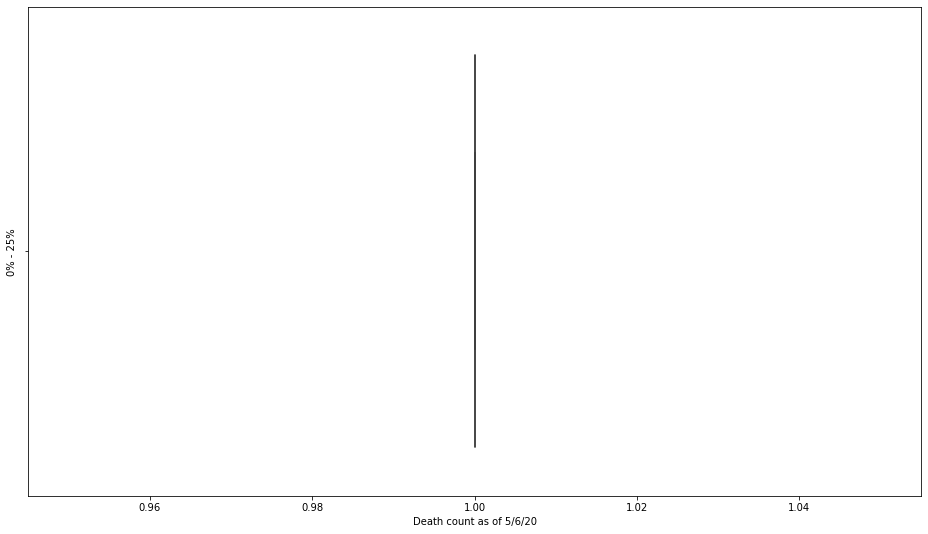

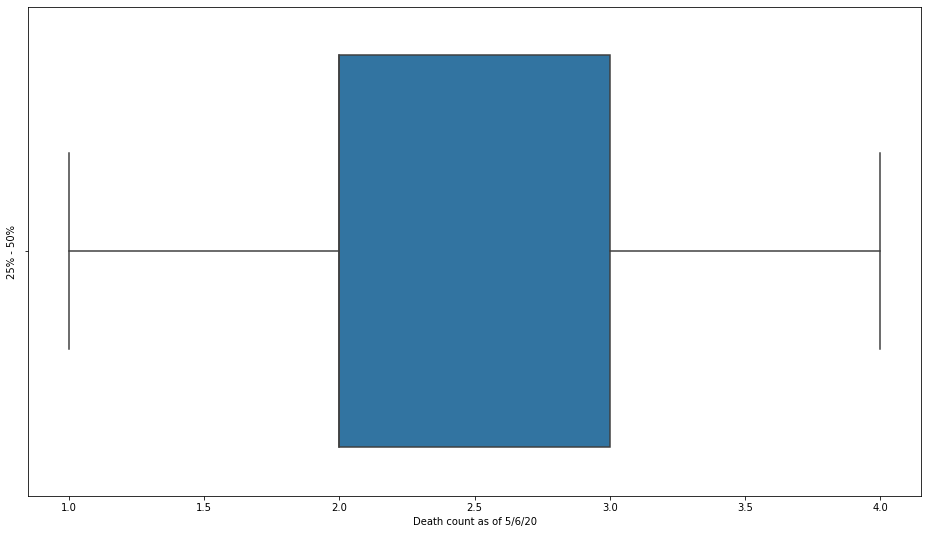

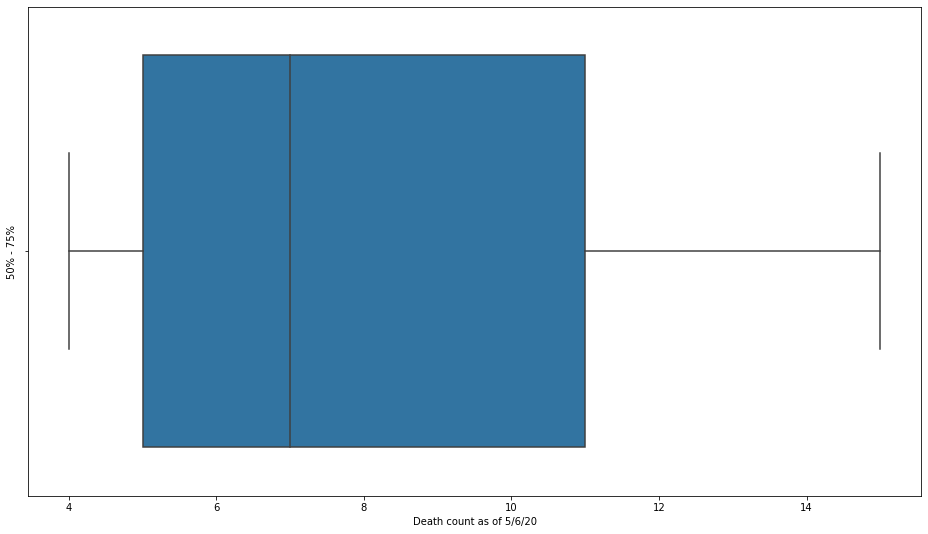

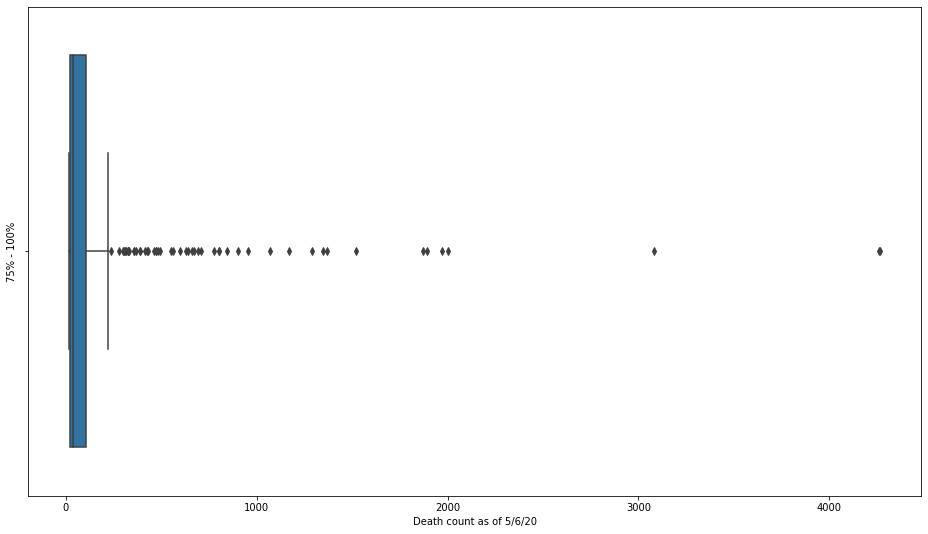

In [31]:
plt.rcParams['figure.figsize'] = [16, 9] # width, height
four_splits = np.array_split(df_covid.iloc[:,-1].sort_values(), 4)

for index, split in enumerate(four_splits):
    plt.ylabel("{}% - {}%".format(index*25, (25+index*25)))
    sns.boxplot(split)
    plt.xlabel("Death count as of {}".format(df_covid.columns[-1]))
    plt.show()

### Generate 4 boxplots of the ICU beds for each county in the above plots  

From these plots, we see that the mean of ICU beds increases as the quartile index increasese. However, the standard deviation increases as well

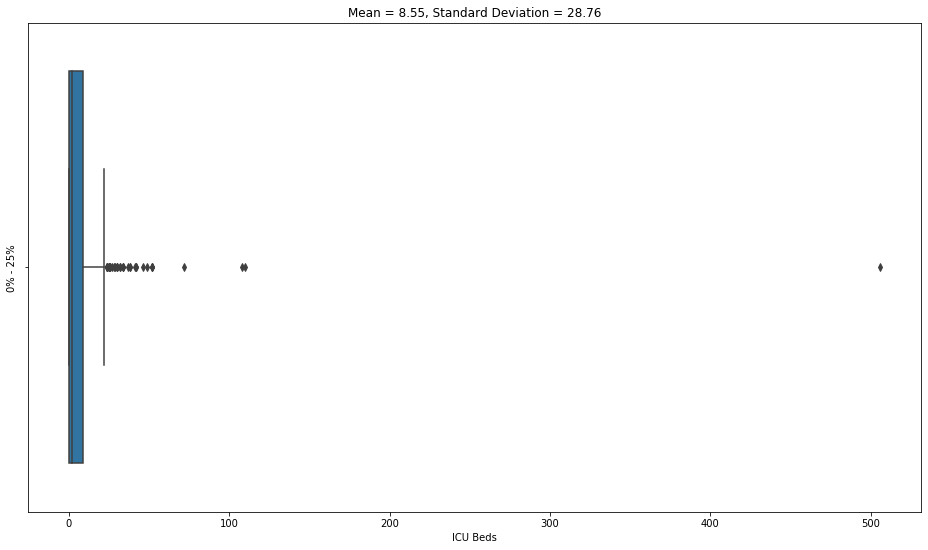

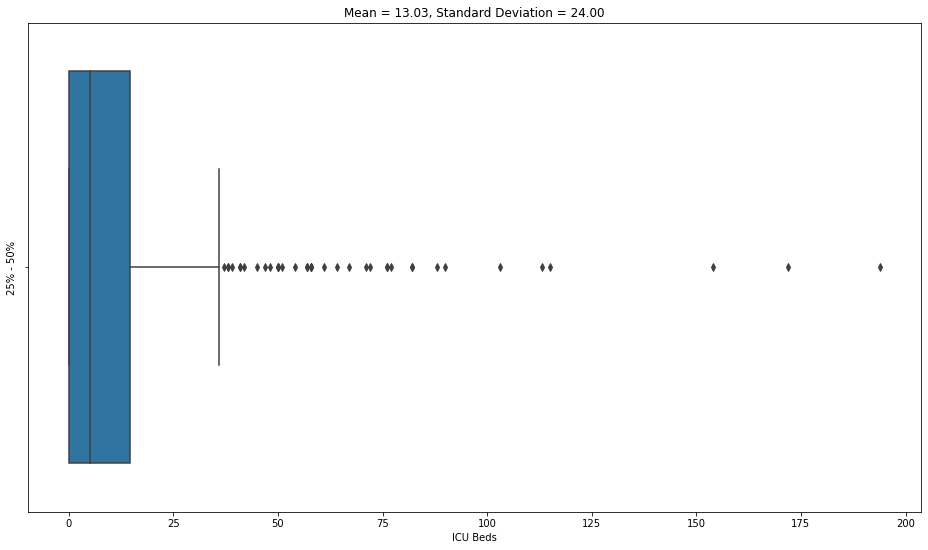

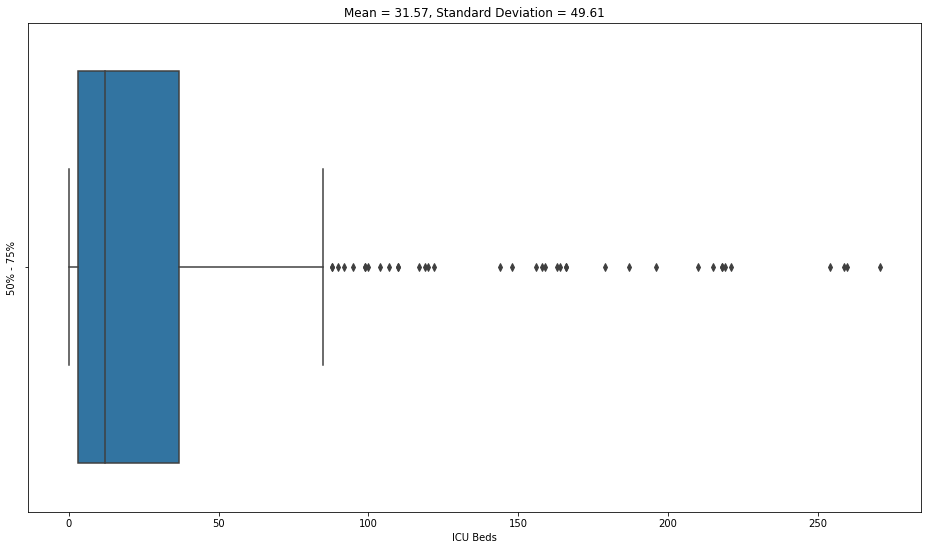

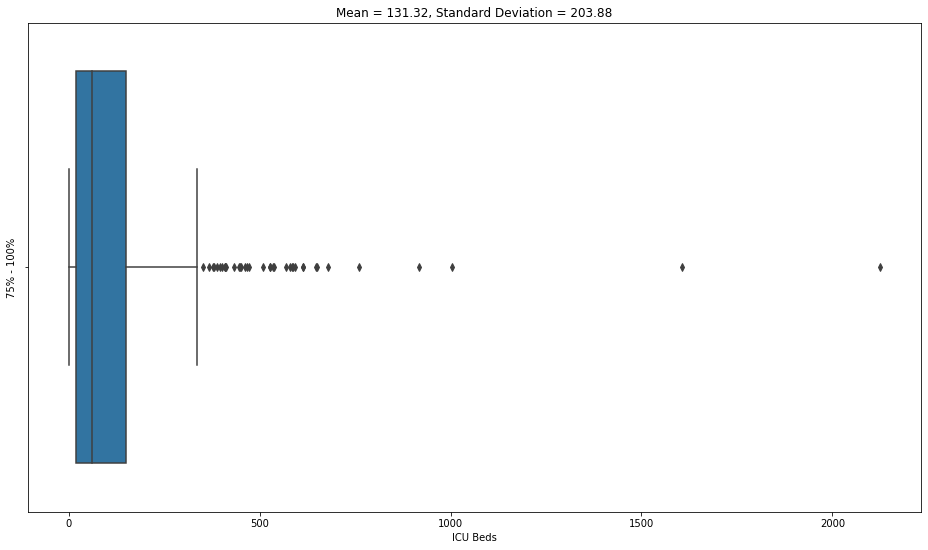

In [32]:
plt.rcParams['figure.figsize'] = [16, 9] # width, height

for index, split in enumerate(four_splits):
    cur_ICU = df_covid.loc[split.index, "ICU Beds"]
    plt.ylabel("{}% - {}%".format(index*25, (25+index*25)))
    sns.boxplot(cur_ICU)
    plt.xlabel("ICU Beds")
    plt.title("Mean = {:.2f}, Standard Deviation = {:.2f}".format(mean(cur_ICU), stdev(cur_ICU)) )
    plt.show()

For this dataset, box plots aren't the best for EDA since there is high variance for all the variables.  
### Below I use Seaborn's regression plot to see how population density affects the most recent death count.

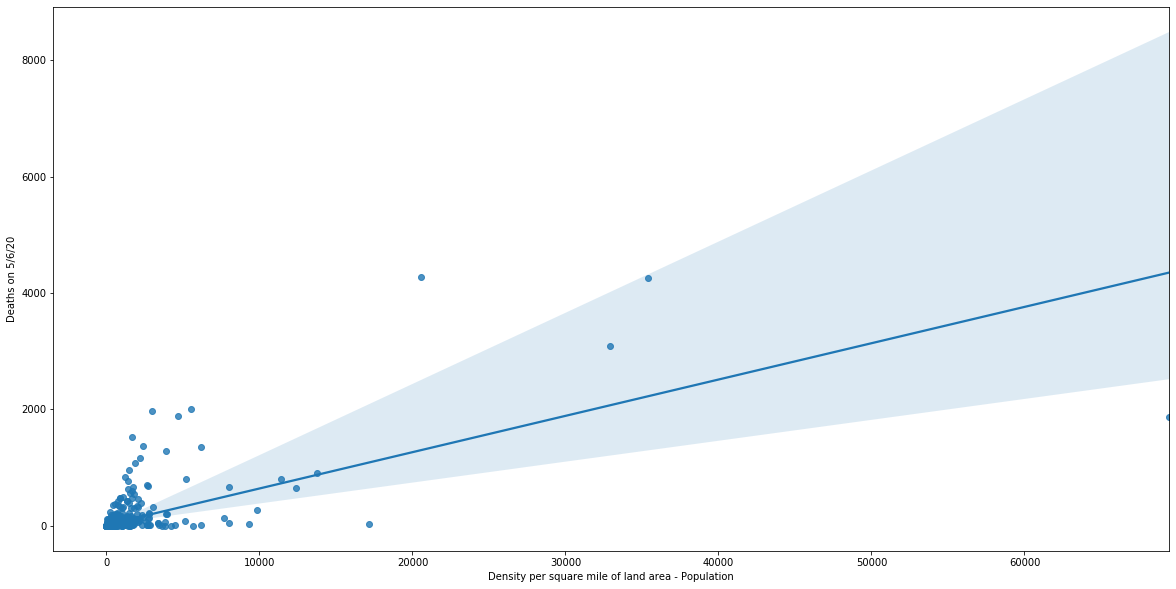

In [33]:
plt.rcParams['figure.figsize'] = [20, 10] # width, height
sns.regplot(x=df_covid["Density per square mile of land area - Population"], y=df_covid.iloc[:,-1])
plt.ylabel("Deaths on {}".format(df_covid.columns[-1]))
plt.show()

### Plot the cumalitive death toll over time for all counties with a registered death

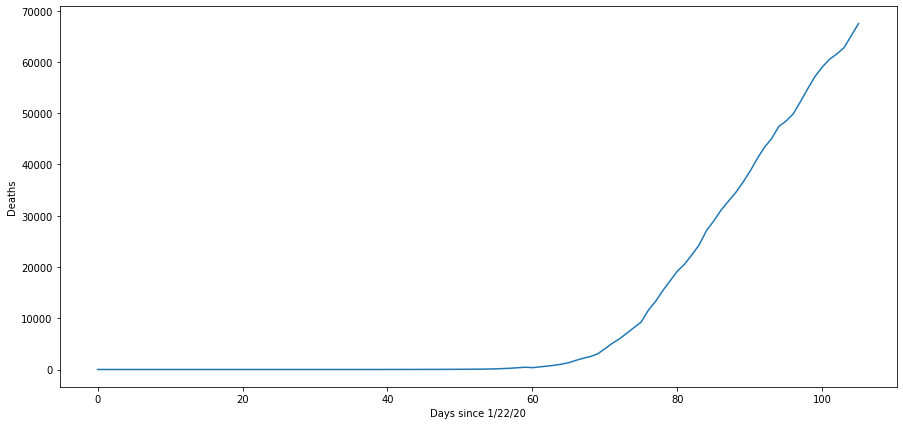

In [34]:
plt.rcParams['figure.figsize'] = [15, 7] # width, height
ax = sns.lineplot(x = list(range(len(df_covid.iloc[:,first_date_col:].columns))), y=df_covid.iloc[:,first_date_col:].apply(lambda col: col.sum()))
plt.xlabel("Days since 1/22/20")
plt.ylabel("Deaths")
plt.show()

### Plot the cumulative death toll over time for NYC

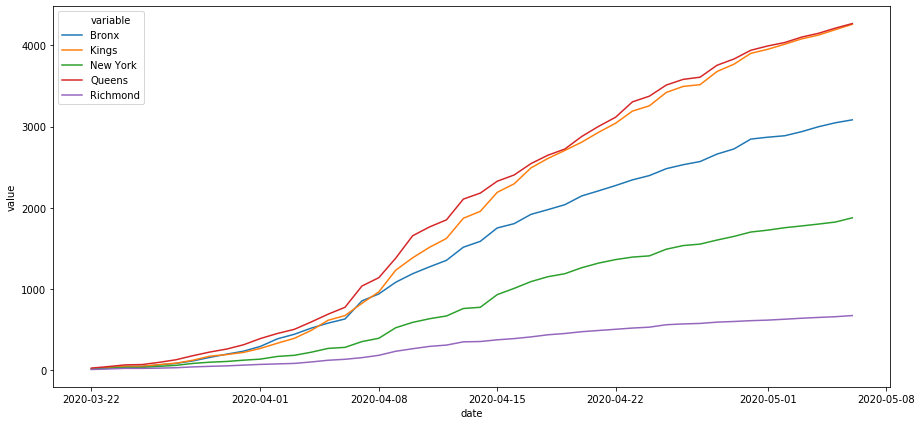

In [35]:
df_nyc_melt = df_nyc.iloc[:,2:7].melt()
# convert to datetime to ensure that seaborn orders plots the dates in order
df_nyc_melt["date"] = pd.to_datetime(np.asarray(5*[df_nyc.timestamp]).flatten())

ax = sns.lineplot(x="date", y="value", hue="variable", data=df_nyc_melt)
#ax.set_xticklabels(df_nyc.timestamp,rotation=60)
plt.show()

### Below is a plot of the NYC death count over time controlling for population

The resulting plot shows that the Bronx is the worst affected borough in terms of amount of deaths per population size. Also, Manhattan drops to the least affected borough.

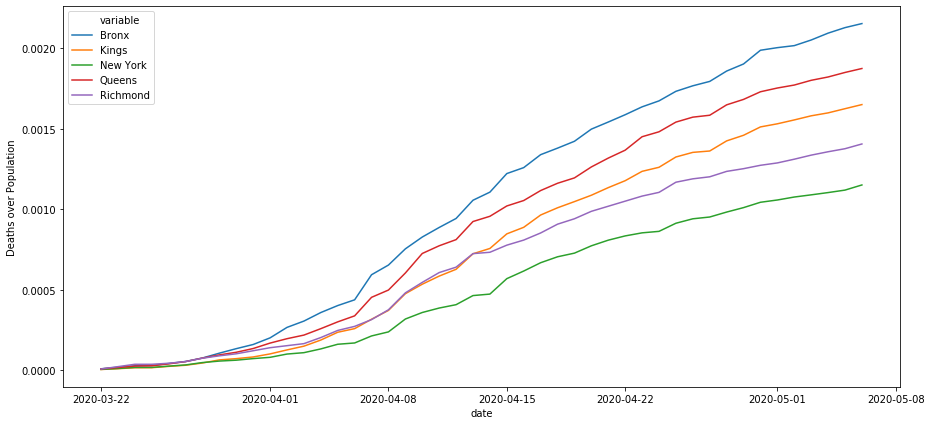

In [36]:
df_nyc_div = df_nyc.copy()
nyc_fips = [36005, 36047, 36061, 36081, 36085] # Bronx, Brooklyn, Manhattan, Queens, Staten Island
boroughs = ["Bronx", "Kings", "New York", "Queens", "Richmond"]
# divide deaths by total population for each day for each borough
for index, fips in enumerate(nyc_fips):
    df_nyc_div[boroughs[index]] = df_nyc[boroughs[index]]/int(df_covid[df_covid.FIPS == fips].POP_ESTIMATE_2018)

df_nyc_div_melt = df_nyc_div.iloc[:,2:7].melt()

# convert to datetime to ensure that seaborn orders plots the dates in order
df_nyc_div_melt["date"] = pd.to_datetime(np.asarray(5*[df_nyc.timestamp]).flatten())

ax = sns.lineplot(x="date", y="value", hue="variable", data=df_nyc_div_melt)
plt.ylabel("Deaths over Population")
plt.show()

### Below I explore the one-hot economic variables.  
First, I look at Rural-Urban_Continuum_Code. Below is a chart mapping its code to its description:

| Code               | Description                                                                        |
|--------------------|------------------------------------------------------------------------------------|
| Metro counties:    |                                                                                    |
| 1                  | Counties in metro areas of 1 million population or more                            |
| 2                  | Counties in metro areas of 250,000 to 1 million population                         |
| 3                  | Counties in metro areas of fewer than 250,000 population                           |
| Nonmetro counties: |                                                                                    |
| 4                  | Urban population of 20,000 or more, adjacent to a metro area                       |
| 5                  | Urban population of 20,000 or more, not adjacent to a metro area                   |
| 6                  | Urban population of 2,500 to 19,999, adjacent to a metro area                      |
| 7                  | Urban population of 2,500 to 19,999, not adjacent to a metro area                  |
| 8                  | Completely rural or less than 2,500 urban population, adjacent to a metro area     |
| 9                  | Completely rural or less than 2,500 urban population, not adjacent to a metro area |
| U.S. total         | 3,143                                                                              |

Below is a chart displaying the number of counties and population of each code:

| Code       | Number of counties | 2010 population |
|------------|--------------------|-----------------|
| Metro      | 1,167              | 262,452,132     |
| 1          | 432                | 168,523,961     |
| 2          | 379                | 65,609,956      |
| 3          | 356                | 28,318,215      |
| Nonmetro   | 1,976              | 46,293,406      |
| 4          | 214                | 13,538,322      |
| 5          | 92                 | 4,953,810       |
| 6          | 593                | 14,784,976      |
| 7          | 433                | 8,248,674       |
| 8          | 220                | 2,157,448       |
| 9          | 424                | 2,610,176       |
| U.S. total | 3,143              | 308,745,538     |

In [37]:
plt.rcParams['figure.figsize'] = [15, 10] # width, height

### Get and plot percentage of counties per code in df_covid --> percentage is simply (# Counties in df_covid) / (# Counties)

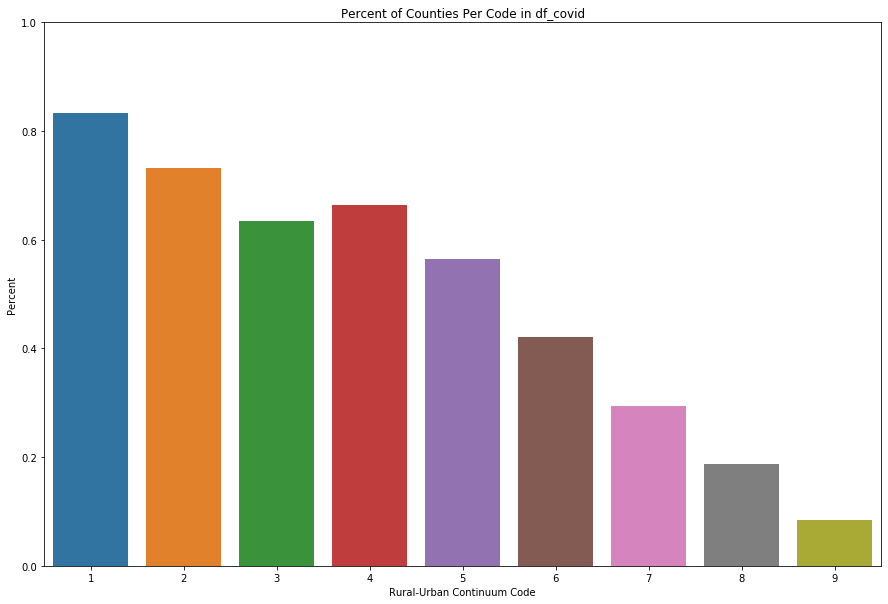

In [38]:
total_counties = [432,379,356,214,92,593,433,220,424]
rural_urban_amts = list()
for index, label in enumerate(rural_labels): # use rural_labels from previous cell (converting categorical to one-hot)
    rural_urban_amts.append(df_covid.loc[:,label].sum()/total_counties[index])

plt.ylim(0,1)
plt.title("Percent of Counties Per Code in df_covid")
plt.xlabel("Rural-Urban Continuum Code")
plt.ylabel("Percent")
sns.barplot(x=list(range(1,10)),y=rural_urban_amts) 
plt.show()

### Now I look at Economic Typology:
- 0=Nonspecialized 
- 1=farm-dependent
- 2=Mining-dependent
- 3=Manufacturing-dependent
- 4=Federal/State government-dependent
- 5=Recreation county  

### Below I plot the total counties of each type in my dataset


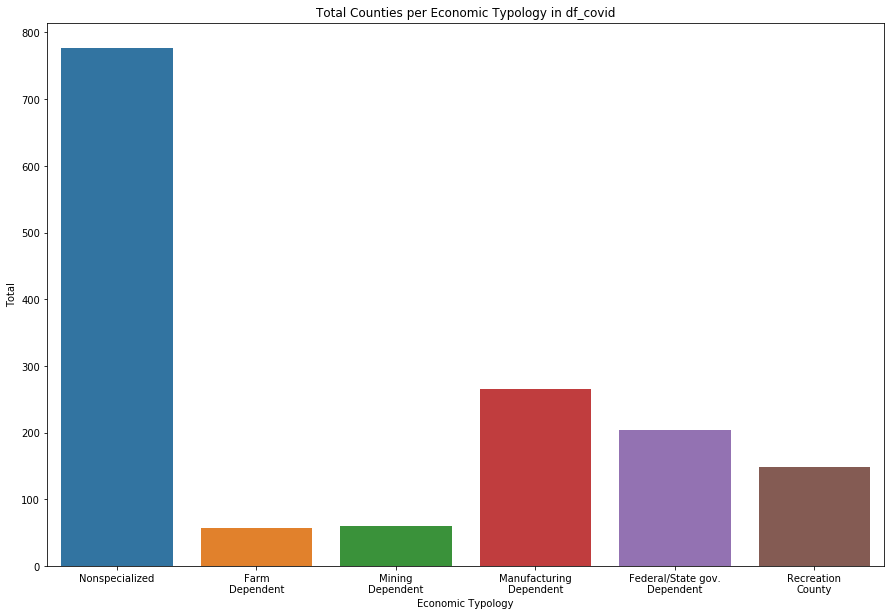

In [39]:
economic_amts = list()
for index, label in enumerate(type_labels): # use rural_labels from previous cell (converting categorical to one-hot)
    economic_amts.append(df_covid.loc[:,label].sum())
    
econ_type_labels = ["Nonspecialized", "Farm\nDependent", "Mining\nDependent", "Manufacturing\nDependent", "Federal/State gov.\nDependent", "Recreation\nCounty"]
plt.title("Total Counties per Economic Typology in df_covid")
plt.xlabel("Economic Typology")
plt.ylabel("Total")
sns.barplot(x=econ_type_labels, y=economic_amts)
plt.show()

It seems that economic typology will not be as useful as I thought since a majority of the counties are nonspecialized. My hypothesis that farm and mining dependent counties have lower amounts of deaths (since they are further from urban areas) seems valid. Perhaps if there was another county classification called "Commuter Dependent" this data would be more useful. "Commuter Dependent" counties are suburban counties where a majority of the workers commute to a city for work e.g. Nassau County (my home county on Long Island).

After doing some research online, it seems that it will be very difficult to perform a regression using a mix of categorical and continuous variables. Also, since the majority of counties are nonspecialized, I don't think that economic typology will contribute well to my model. I am dissapointed because I was very excited to use these cool economic variables. Perhaps, I will revisit them in a future project. Below I drop these variables from df_covid.

In [40]:
df_covid = df_covid.drop(df_covid.iloc[:,df_covid.columns.get_loc("Rural-Urban_Continuum_Code = 1"):first_date_col].columns, axis=1)

## Feature Selection & Dimensionality Reduction  

In [41]:
# 1/22/20 is the first date in df_covid --> get column number of first date in df_covid
first_date_col = df_covid.columns.get_loc("1/22/20")

 ### First, I will use a univariate approach and remove parameters that are highly correlated

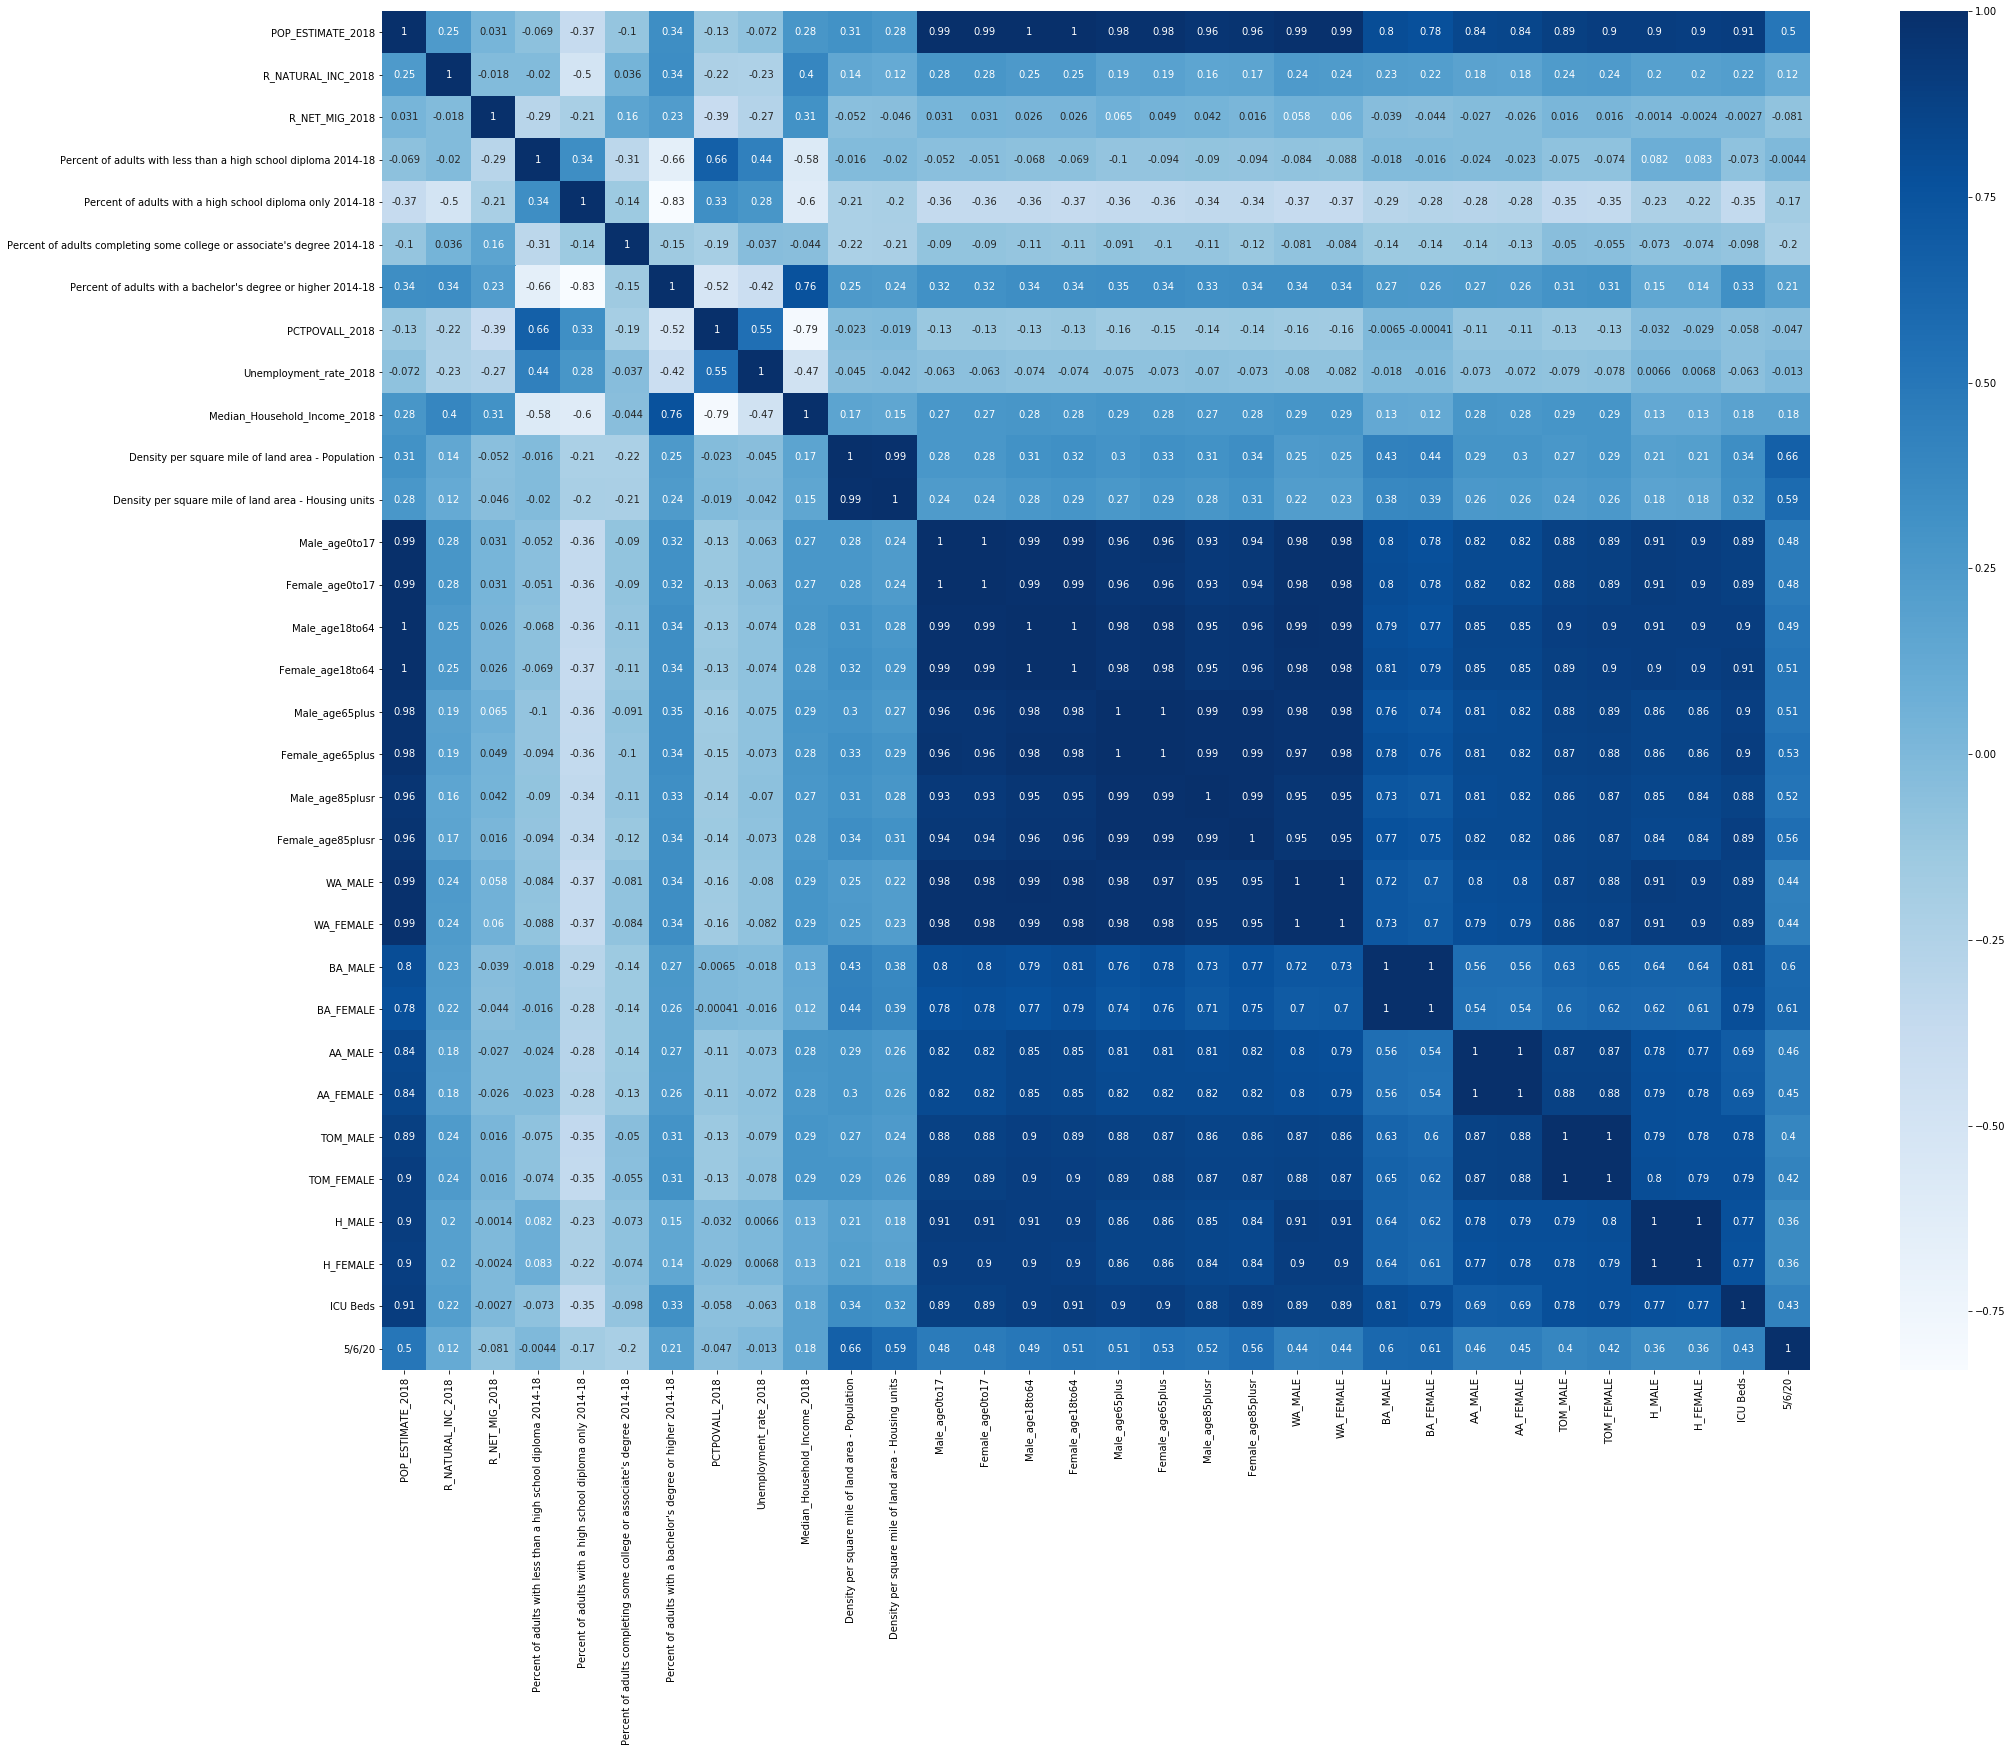

In [44]:
plt.rcParams['figure.figsize'] = [32, 25] # width, height
sns.heatmap(df_covid.iloc[:,list(range(3,first_date_col)) + [-1]].corr(), cmap="Blues", annot=True)
plt.show()

From the above heatmap I notice the following:  

1) "Density per square mile of land area - Population" and "Density per square mile of land area - Housing Units" are strongly correlated. I will remove the housing units density since population density is more correlated with the death count of our most recent date.

2) Also, the population estimate equals the sum of the male and femal age ranges. For regressions, I do not want an independent variable to be a function of the other independent variables. Also, population density seems more important from a heuristic view, so I will drop POP_ESTIMATE_2018 as well.  

3) "Median household income" is strongly correlated with "percent of adults with a bachelors degree or higher". However, I do not want to drop one of these features yet since they are two different stats. I will let the more advanced multivariate approaches decide if one of these features should be dropped.

4) There is a 'square' of mostly strong correlations between the age ranges and the ethnicity data. As I mentioned in 3), these stats are different so I would like to see what the multivariate approaches think

5) ICU beds is highly correlated to population estimate and the age ranges and ethnicity data. I will keep this stat for now because I think it is a cool stat and I am already dropping population estimate. It is not as strongly correlated to population density which is interesting as well.





In [45]:
df_covid = df_covid.drop(["POP_ESTIMATE_2018", "Density per square mile of land area - Housing units"], axis=1)
first_date_col -= 2 # update the column number of 1/22/20

### Select k-best

In [46]:
fs = SelectKBest(score_func=f_regression, k=10)
selected_vars = fs.fit(df_covid.iloc[:,list(range(3,first_date_col))], df_covid.iloc[:,-1])
display(df_covid.iloc[:,list(range(3,first_date_col))].columns[selected_vars.get_support()])

Index(['Density per square mile of land area - Population', 'Male_age0to17',
       'Male_age18to64', 'Female_age18to64', 'Male_age65plus',
       'Female_age65plus', 'Male_age85plusr', 'Female_age85plusr', 'BA_MALE',
       'BA_FEMALE'],
      dtype='object')

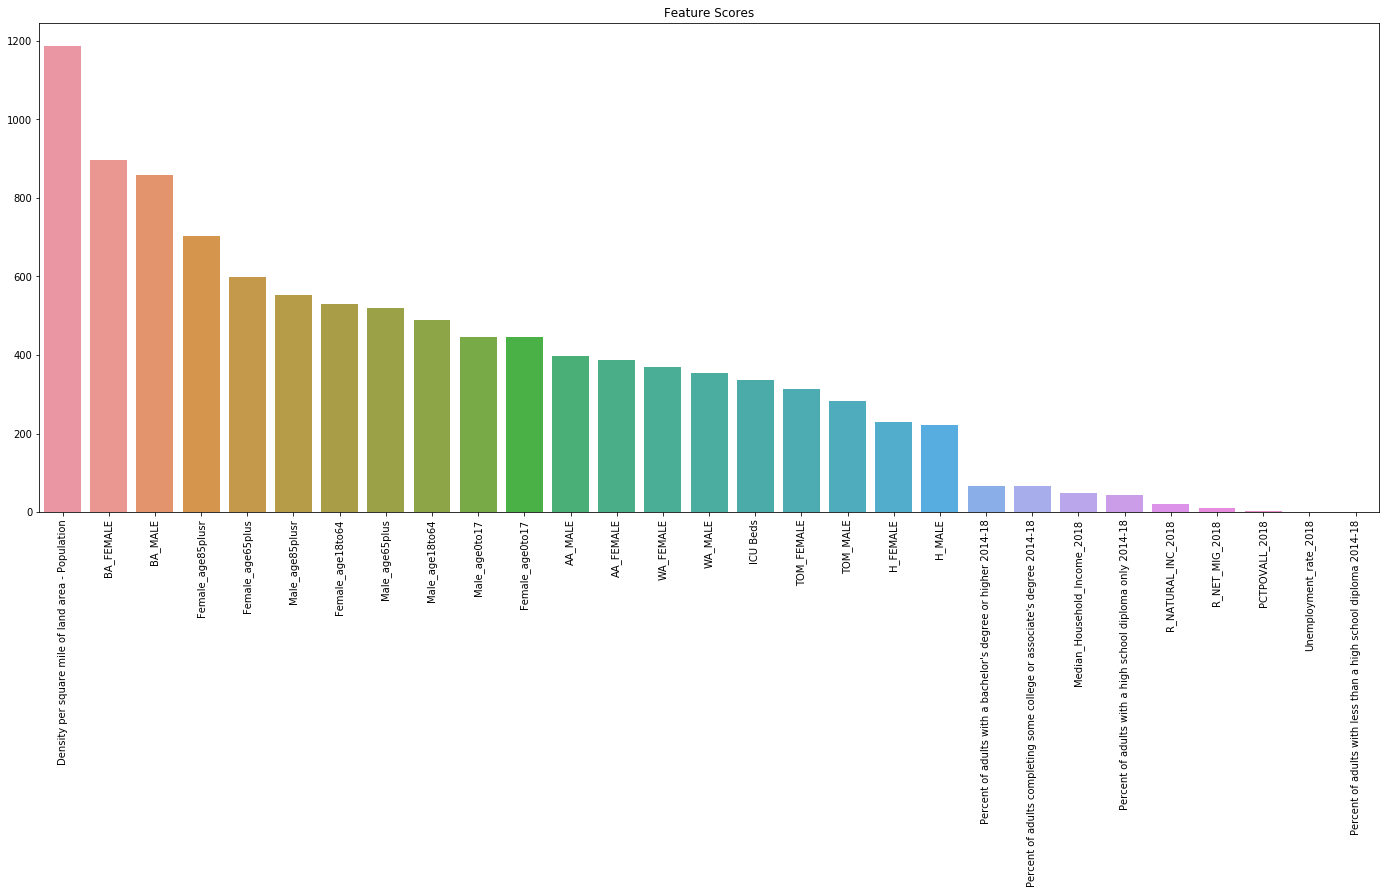

In [47]:
columns = df_covid.iloc[:,list(range(3,first_date_col))].columns

# define a dictionary where keys are column names and values are scores
col_val = dict(zip(columns, selected_vars.scores_))

# define a dictionary where keys are feature importances and values are column names
val_col = dict(zip(selected_vars.scores_, columns))

# Create descending lists of column names and correpsonding feature importances
sorted_cols = list()
for i in sorted(val_col.keys()):
    for key, value in col_val.items():
        if (value == i):
            sorted_cols.append(key)
            
sorted_cols = sorted_cols[::-1] # get descending order
sorted_vals = sorted(val_col.keys())[::-1] # get descending order

dict_kbest = dict(zip(sorted_cols,sorted_vals))

# Create plot
plt.rcParams['figure.figsize'] = [24, 9] # width, height
ax = sns.barplot(x=sorted_cols, y=sorted_vals)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title("Feature Scores")
plt.show()

## Now I will explore some multivariate approaches

### Forward Selection  
Ref: https://towardsdatascience.com/feature-selection-using-wrapper-methods-in-python-f0d352b346f

In [48]:
sfs_f = SFS(LinearRegression(), k_features=10, forward=True, scoring='r2', cv=0) # If i use cross validation, I get a negative r^2...
sfs_f.fit(df_covid.iloc[:,list(range(3,first_date_col))], df_covid.iloc[:,-1])

# get list of features added in order
f_ordered_features = []
for i in range(1,11):
    for feature in sfs_f.subsets_[i]["feature_names"]:
        if (feature not in f_ordered_features):
            f_ordered_features.append(feature)
            continue
f_ordered_features

['Density per square mile of land area - Population',
 'Female_age85plusr',
 'Male_age85plusr',
 'ICU Beds',
 'BA_FEMALE',
 'BA_MALE',
 'TOM_MALE',
 "Percent of adults with a bachelor's degree or higher 2014-18",
 'H_MALE',
 'Male_age0to17']

C:\Users\ahawk\Anaconda3\envs\csci349\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\ahawk\Anaconda3\envs\csci349\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars



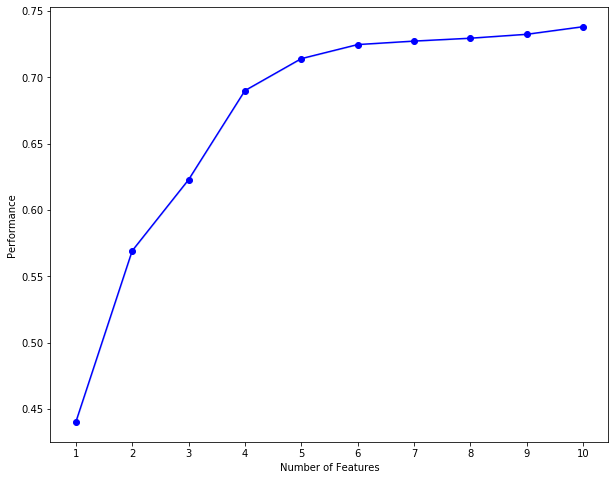

In [49]:
plt.rcParams['figure.figsize'] = [10, 8] # width, height
plot_sfs(sfs_f.get_metric_dict(), kind='std_dev')
plt.show()

#### Backward Elimination

In [50]:
# Setting forward=False is the only difference, in terms of parameters, between forward selection & backward elimination
sfs_b = SFS(LinearRegression(), k_features=1, forward=False, scoring='r2', cv=0) # k_features=1 since I want to get the order of the last 10 removed features
sfs_b.fit(df_covid.iloc[:,list(range(3,first_date_col))], df_covid.iloc[:,-1])

# get list of features added in order
b_ordered_features = []
for i in range(1,11):
    for feature in sfs_b.subsets_[i]["feature_names"]:
        if (feature not in b_ordered_features):
            b_ordered_features.append(feature)
            continue
b_ordered_features

['Density per square mile of land area - Population',
 'Female_age85plusr',
 'Male_age85plusr',
 'ICU Beds',
 'WA_MALE',
 'Male_age0to17',
 'TOM_MALE',
 'Female_age0to17',
 'Male_age65plus',
 'Female_age18to64']

C:\Users\ahawk\Anaconda3\envs\csci349\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\ahawk\Anaconda3\envs\csci349\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars



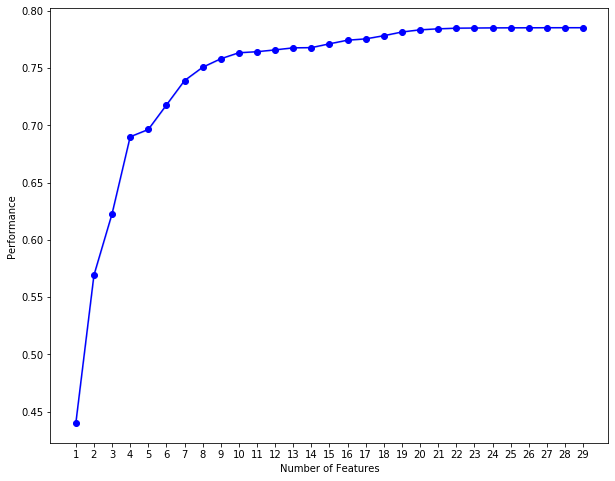

In [51]:
plt.rcParams['figure.figsize'] = [10, 8] # width, height
plot_sfs(sfs_b.get_metric_dict(), kind='std_dev')
plt.show()

#### Random Forest  
Ref: https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f  

train data is the county socioeconomic variables  
my test data is the most recent death count for a county  

In [52]:
# split into train and test data
x_train,x_test,y_train,y_test = train_test_split(df_covid.iloc[:,list(range(3,first_date_col))], df_covid.iloc[:,-1], test_size=0.3)

feature_select = SelectFromModel(RandomForestRegressor(n_estimators=1000, verbose=1))
feature_select.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   38.6s finished


SelectFromModel(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                                criterion='mse', max_depth=None,
                                                max_features='auto',
                                                max_leaf_nodes=None,
                                                max_samples=None,
                                                min_impurity_decrease=0.0,
                                                min_impurity_split=None,
                                                min_samples_leaf=1,
                                                min_samples_split=2,
                                                min_weight_fraction_leaf=0.0,
                                                n_estimators=1000, n_jobs=None,
                                                oob_score=False,
                                                random_state=None, verbose=1,
                                                wa

### Plot the feature importances below

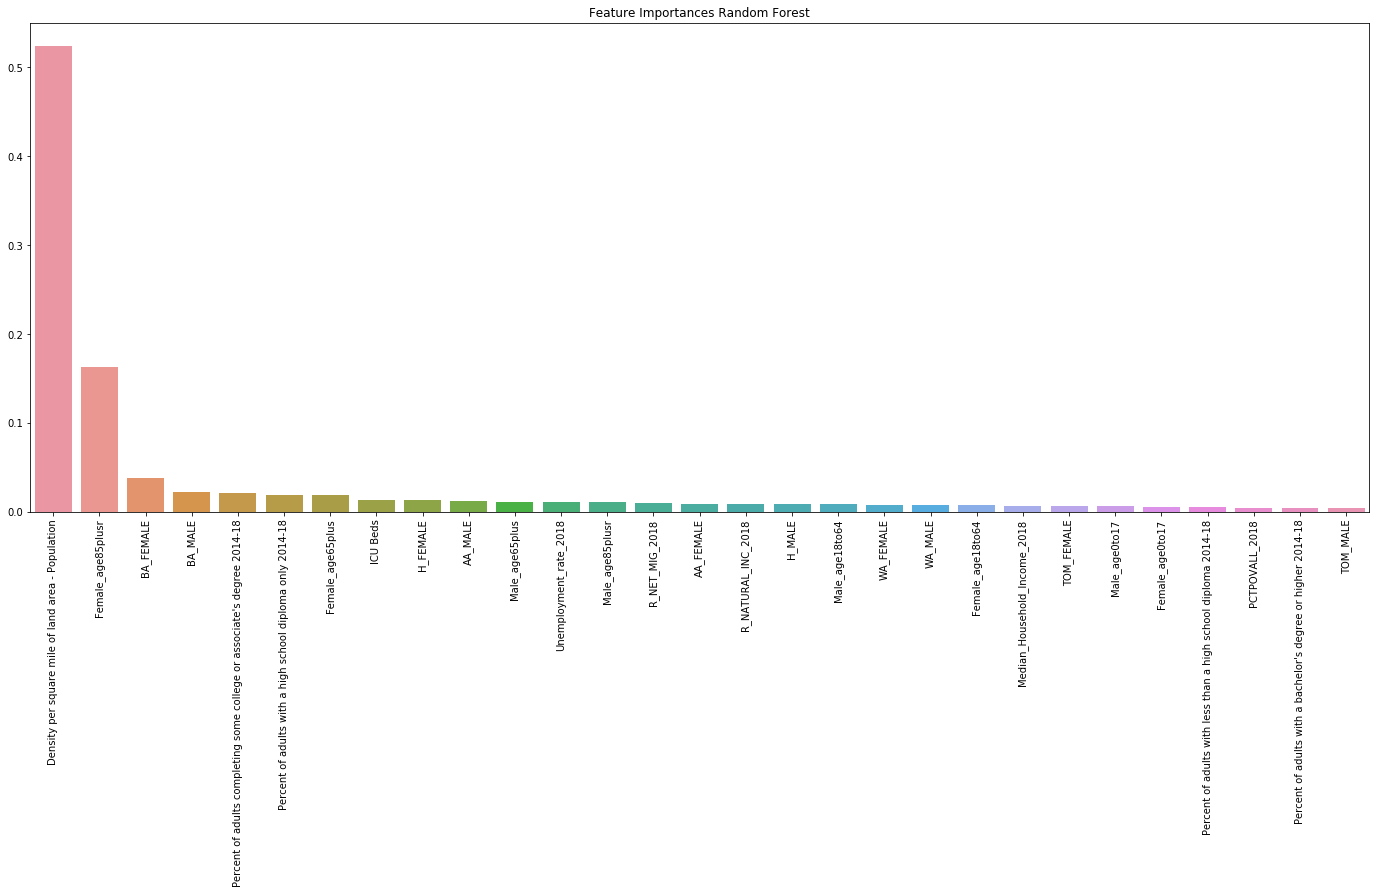

In [53]:
# define a dictionary where keys are column names and values are corresponding feature importances
col_val = dict(zip(df_covid.iloc[:,list(range(3,first_date_col))].columns, feature_select.estimator_.feature_importances_))

# define a dictionary where keys are feature importances and values are column names
val_col = dict(zip(feature_select.estimator_.feature_importances_, df_covid.iloc[:,list(range(3,first_date_col))].columns))

# Create descending lists of column names and correpsonding feature importances
sorted_cols = list()
for i in sorted(val_col.keys()):
    for key, value in col_val.items():
        if (value == i):
            sorted_cols.append(key)
            
sorted_cols = sorted_cols[::-1] # get descending order
sorted_vals = sorted(val_col.keys())[::-1] # get descending order

dict_trees = dict(zip(sorted_cols,sorted_vals))

# Create plot
plt.rcParams['figure.figsize'] = [24, 9] # width, height
ax = sns.barplot(x=sorted_cols, y=sorted_vals)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title("Feature Importances Random Forest")
plt.show()

#### Now I will use k-fold to find the feature importances

In [58]:
splits=10
kfold = KFold(n_splits = splits, shuffle=True, random_state=123)

column_names = df_covid.iloc[:,list(range(3,first_date_col))].columns

# Initialize a dictionary of feature values with zeros --> this will be updated with the features values generated during each fold
dict_feature_values = dict(zip(column_names, np.zeros(first_date_col-2)))

for train, test in kfold.split(df_covid):
    print("Starting Fold")
    print(train)
    feature_select = SelectFromModel(RandomForestRegressor(n_estimators=1000, verbose=1, n_jobs=3))
    feature_select.fit(df_covid.iloc[train,list(range(3,first_date_col))], df_covid.iloc[train,-1])
    # update the total feature values
    dict_update_values = dict(zip(column_names, feature_select.estimator_.feature_importances_))
    for key in dict_feature_values.keys():
        dict_feature_values[key] += dict_update_values[key]
        
# get the average feature value
for key in dict_feature_values.keys():
    dict_feature_values[key] /= splits

Starting Fold
[   0    1    2 ... 1508 1509 1510]


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.4s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.1s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:   18.4s
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:   23.2s finished


Starting Fold
[   0    1    2 ... 1508 1509 1510]


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.6s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.7s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:   19.0s
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:   24.1s finished


Starting Fold
[   0    1    2 ... 1507 1508 1510]


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.7s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.6s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:   19.0s
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:   23.6s finished


Starting Fold
[   0    1    2 ... 1508 1509 1510]


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.4s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.4s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:   18.6s
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:   23.3s finished


Starting Fold
[   0    1    2 ... 1508 1509 1510]


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.3s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:   18.6s
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:   23.4s finished


Starting Fold
[   1    2    3 ... 1508 1509 1510]


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.3s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:   18.5s
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:   23.5s finished


Starting Fold
[   0    1    2 ... 1508 1509 1510]


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.3s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.1s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:   18.4s
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:   23.2s finished


Starting Fold
[   0    1    2 ... 1508 1509 1510]


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.5s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:   18.9s
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:   23.7s finished


Starting Fold
[   0    2    3 ... 1508 1509 1510]


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.3s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:   18.7s
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:   23.7s finished


Starting Fold
[   0    1    4 ... 1506 1507 1509]


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.5s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:   18.8s
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:   24.0s finished


#### Plot the results of the k-fold feature selector

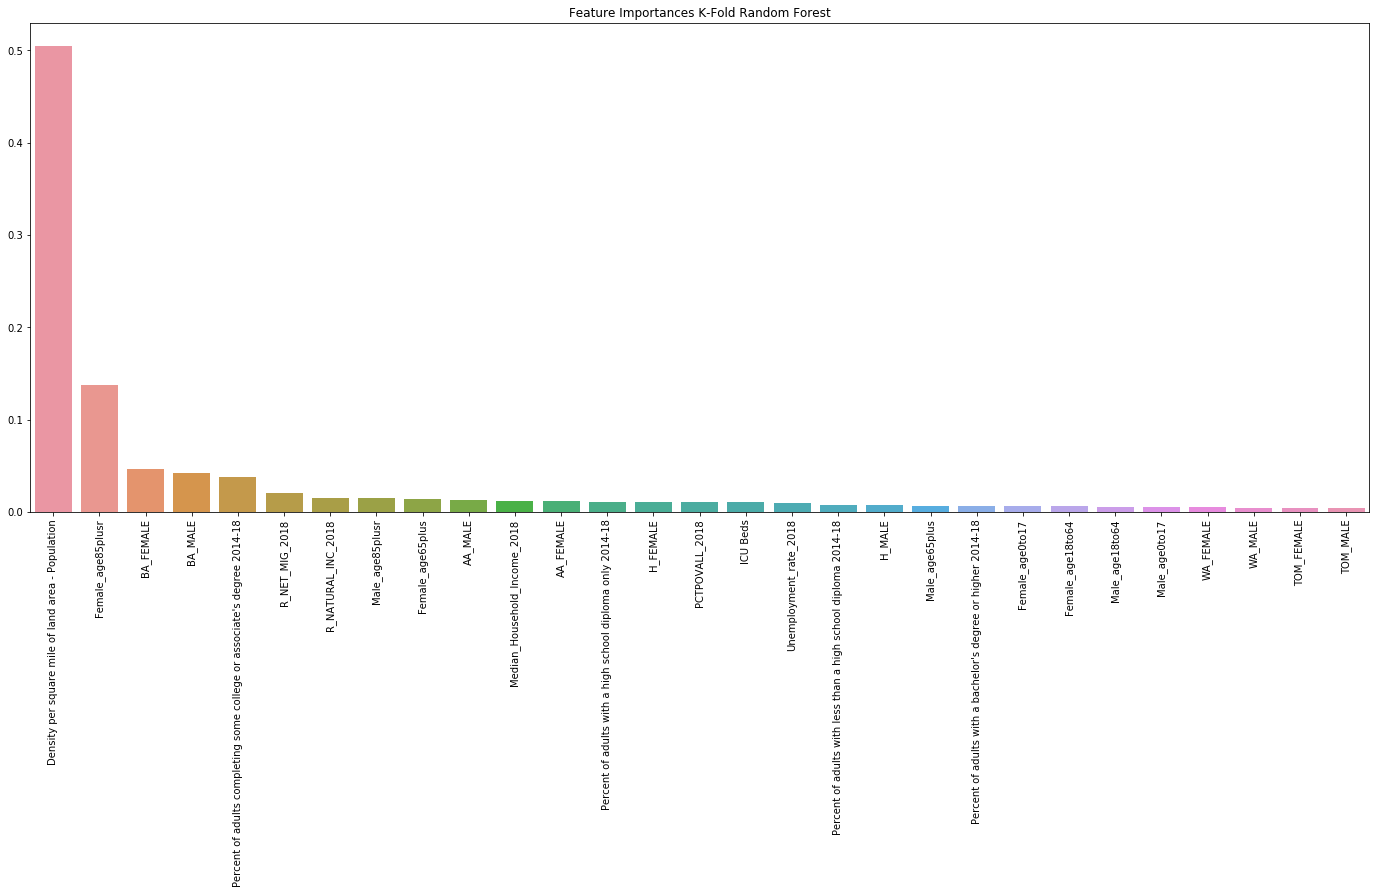

In [59]:
# define a dictionary where keys are feature importances and values are column names
val_col = dict(zip(dict_feature_values.values(), dict_feature_values.keys()))

# Create descending lists of column names and correpsonding feature importances
sorted_cols = list()
for i in sorted(val_col.keys()):
    for key, value in dict_feature_values.items():
        if (value == i):
            sorted_cols.append(key)
            
sorted_cols = sorted_cols[::-1] # get descending order
sorted_vals = sorted(val_col.keys())[::-1] # get descending order

dict_trees_kfold = dict(zip(sorted_cols,sorted_vals))

# Create plot
plt.rcParams['figure.figsize'] = [24, 9] # width, height
ax = sns.barplot(x=sorted_cols, y=sorted_vals)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title("Feature Importances K-Fold Random Forest")
plt.show()

#### Plot the sum of the feature_importance.  
The top 6 features explain ~80% of the target variable and ~15 features explain ~90% of the target variable. From these results, I feel comfortable choosing 10 features for the RNN model.

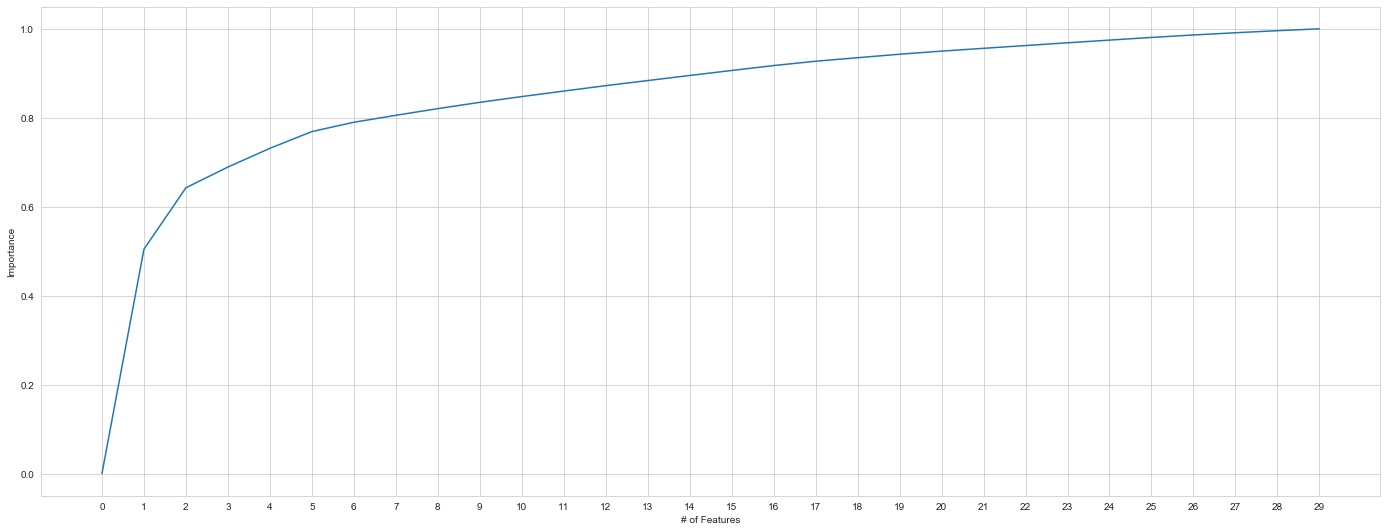

In [62]:
sum_of_importance = [0]
for value in dict_trees_kfold.values():
    sum_of_importance.append(sum_of_importance[-1]+value)
sns.set_style("whitegrid")
plt.xticks(list(range(len(dict_trees_kfold)+1)))
sns.lineplot(x=list(range(len(dict_trees_kfold)+1)), y=sum_of_importance)
plt.xlabel("# of Features")
plt.ylabel("Importance")
plt.show()

#### Below I compare the results of the above feature selections

In [63]:
pd.DataFrame({"k_best":list(dict_kbest.keys())[:10], "forward":f_ordered_features, "backward":b_ordered_features, "Random Forest":list(dict_trees.keys())[:10], "K-Fold Random Forest":list(dict_trees_kfold.keys())[:10]})

,k_best,forward,backward,Random Forest,K-Fold Random Forest
0,Density per square mile of land area - Population,Density per square mile of land area - Population,Density per square mile of land area - Population,Density per square mile of land area - Population,Density per square mile of land area - Population
1,BA_FEMALE,Female_age85plusr,Female_age85plusr,Female_age85plusr,Female_age85plusr
2,BA_MALE,Male_age85plusr,Male_age85plusr,BA_FEMALE,BA_FEMALE
3,Female_age85plusr,ICU Beds,ICU Beds,BA_MALE,BA_MALE
4,Female_age65plus,BA_FEMALE,WA_MALE,Percent of adults completing some college or a...,Percent of adults completing some college or a...
5,Male_age85plusr,BA_MALE,Male_age0to17,Percent of adults with a high school diploma o...,R_NET_MIG_2018
6,Female_age18to64,TOM_MALE,TOM_MALE,Female_age65plus,R_NATURAL_INC_2018
7,Male_age65plus,Percent of adults with a bachelor's degree or ...,Female_age0to17,ICU Beds,Male_age85plusr
8,Male_age18to64,H_MALE,Male_age65plus,H_FEMALE,Female_age65plus
9,Male_age0to17,Male_age0to17,Female_age18to64,AA_MALE,AA_MALE


From these results, I choose the top 10 features to include in the RNN model. Since 6 features sum to 80% of the importance for k-fold random forest, the next 4 features I choose can be features I am interested in. Explanations for why I chose some of the variables are below:

1) **"Density per square mile of land area - Population"** - it is the top feature for all selection methods  
2) **"ICU Beds"** - I included this variable since it is #4 for both forward and backward. It is also a cool variable.  
3) **R_NET_MIG_2018** - I trust the resuls of teh K-Fold Random Forest the most since it seems to be the most robust feature selector. Also, net migration realtes to people moving in and out of a county, which potentially is correlated to the spread of the virus.  
4) **Male_age0to17** - this is the variable I am most unsure of, but it appears in the top-10 for k_best, forward and backward, so I'll give it a chance. Also, I have a hunch that middle schoolers and high schoolers are more likely to wander around now and potentially spread the virus since they are not in school anymore.


In [64]:
best_features = ["Density per square mile of land area - Population", "Female_age85plusr", "Male_age85plusr", "BA_FEMALE", "BA_MALE", "R_NET_MIG_2018", 
                 "Percent of adults completing some college or associate's degree 2014-18", "Male_age0to17", "Median_Household_Income_2018", "ICU Beds"]
len(best_features)

10

# Model  
In my modeling notebook, I go through many regression models using different features. I observe the effectiveness of the OLS, Ridge, Lasso, and Support Vector Regression using the following features: all features of the cleaned dataset, best_feaure, and the top-5 features of the k-fold random forest selector. All of these models behaved similarly, and had MAEs in the 35-50 range with RMSE in the 125-160 range. These models were not using any death time-series'. Instead they only used the total deaths on the most recent date. To evaluate the performances of these models, I used a simple cross validation scheme with 10 folds, where the total deaths on the most recent date were the target variables. Honestly, the results were not as great as the MAE and RMSE lead me to believe at first. Upon further investigation, I noticed that some of the predicted deaths were negative and most were simply way off. For the 5 boroughs, the predictions were several hundred away. THe MAE and RMSE were seemingly good because the death count for a majority of the counties is below 10. For example, I observed on a multitude of occasions that the actual death count for a county is 1, but the predicted is -15. These results were not good, and I was very concerned.   

However, I then realized how I can easily integrate my death time-series' data into my regression model. I moved the dates from the columns of df_covid to the index of df_covid by applying the melt function. This means that every date,county pair is represented. I then added in columns that kept track of the days since the first date (I chose the first date to be 3/14 since this date had a small total death count for all counties), and columns to keep track of the number of deaths per county over the previous 4 days. I used a simple OLS regression with the top-5 features from the k-fold random forest selector and the results were shockingly accurate. If I had more time, I would have experimented with different regression models, features and hyprparameters. The model is shown below.

In [65]:
# Get dataset with top-5 features of k-fold random forest
# start on 3/14 --> 56 total deaths
start_date_col = df_covid.columns.get_loc("3/14/20")
keep_cols = list(df_covid.iloc[:,:3]) + ["Density per square mile of land area - Population", "Female_age85plusr", "BA_FEMALE", "BA_MALE", 
                                         "Percent of adults completing some college or associate's degree 2014-18"] + list(df_covid.iloc[:,start_date_col:].columns)
df_covid_5 = df_covid.loc[:,keep_cols]

num_dates = df_covid_5.iloc[:,8:].shape[1]

df_dates_melt = df_covid_5.iloc[:,8:].melt().rename(columns={"variable": "Date", "value": "Deaths"})


df_covid_5_concat = pd.concat([df_covid_5.iloc[:,:8]]*num_dates, ignore_index=True)

df_covid_5_concat.shape

df_covid_5_concat = pd.concat([df_covid_5_concat, df_dates_melt], axis=1, sort=False)


num_counties = df_covid.shape[0]
days_since_start = list()
for i in range(num_dates):
    days_since_start.append(num_counties*[i])
days_since_start = np.asarray(days_since_start).flatten()
days_since_start.shape

df_covid_5_concat["Days_Since_Start"] = days_since_start

df_covid_5_concat = df_covid_5_concat.set_index("Date", drop=True)
df_covid_5_concat

death_list = list(df_covid_5_concat.Deaths)
df_covid_5_concat["Deaths-1"] = (list(np.zeros(num_counties)) + death_list[:(len(death_list)-num_counties)])
df_covid_5_concat["Deaths-2"] = (list(np.zeros(2*num_counties)) + death_list[:(len(death_list)-2*num_counties)])
df_covid_5_concat["Deaths-3"] = (list(np.zeros(3*num_counties)) + death_list[:(len(death_list)-3*num_counties)])
df_covid_5_concat["Deaths-4"] = (list(np.zeros(4*num_counties)) + death_list[:(len(death_list)-4*num_counties)])

df_covid_5_concat = df_covid_5_concat.reindex(columns = ["FIPS", "County", "State", "Density per square mile of land area - Population", "Female_age85plusr", "BA_FEMALE", "BA_MALE", 
                                         "Percent of adults completing some college or associate's degree 2014-18", "Days_Since_Start","Deaths-4", "Deaths-3", "Deaths-2", "Deaths-1", "Deaths"])

print(df_covid_5_concat.shape)
print(df_covid_5_concat.info())

(81594, 14)
<class 'pandas.core.frame.DataFrame'>
Index: 81594 entries, 3/14/20 to 5/6/20
Data columns (total 14 columns):
 #   Column                                                                   Non-Null Count  Dtype  
---  ------                                                                   --------------  -----  
 0   FIPS                                                                     81594 non-null  int32  
 1   County                                                                   81594 non-null  object 
 2   State                                                                    81594 non-null  object 
 3   Density per square mile of land area - Population                        81594 non-null  float32
 4   Female_age85plusr                                                        81594 non-null  int32  
 5   BA_FEMALE                                                                81594 non-null  int32  
 6   BA_MALE                                                 

#### Below we see that the sudo-death time-series looks good

In [66]:
df_covid_5_concat[df_covid_5_concat.County == "Queens"].iloc[[-1],:]

,FIPS,County,State,Density per square mile of land area - Population,Female_age85plusr,BA_FEMALE,BA_MALE,Percent of adults completing some college or associate's degree 2014-18,Days_Since_Start,Deaths-4,Deaths-3,Deaths-2,Deaths-1,Deaths
Date,,,,,,,,,,,,,,
5/6/20,36081,Queens,New York,20553.599609,33287,255651,216256,22.4,53,4035.0,4102.0,4149.0,4213.0,4269


# Results

### Below, I use the first 51 dates of data as my training data, and I use day 52 as my testing data.

In [67]:
x_train = df_covid_5_concat.iloc[:num_counties*52,3:-1]
y_train = df_covid_5_concat.iloc[:num_counties*52,-1]
x_test = df_covid_5_concat.iloc[num_counties*52:,3:-1]
y_test = df_covid_5_concat.iloc[num_counties*52:,-1]

reg = LinearRegression().fit(x_train, y_train)
predictions = reg.predict(x_test)
print("R^2: {}".format(reg.score(x_test,y_test)))
print("MAE: {}".format(mean_absolute_error(y_test, predictions)))
print("RMSE: {}".format(mean_squared_error(y_test, predictions, squared=False)))

R^2: 0.9995028942463619
MAE: 1.0819072136952173
RMSE: 5.095452016624751


#### Below I observe how the predicted death counts compare to the actual death counts in New York

In [72]:
df_results = x_test
df_results["Actual Deaths"] = y_test
df_results["Predicted Deaths"] = predictions
df_results["FIPS"] = df_covid_5_concat.iloc[num_counties*52:,0]
df_results["County"] = df_covid_5_concat.iloc[num_counties*52:,1]
df_results["State"] = df_covid_5_concat.iloc[num_counties*52:,2]
display(df_results[df_results.State=="New York"].iloc[:,10:][:20])
display(df_results[df_results.State=="New York"].iloc[:,10:][20:40])
display(df_results[df_results.State=="New York"].iloc[:,10:][40:60])
display(df_results[df_results.State=="New York"].iloc[:,10:][60:])

,Actual Deaths,Predicted Deaths,FIPS,County,State
Date,,,,,
5/5/20,49,51.515936,36001,Albany,New York
5/5/20,3046,3049.587265,36005,Bronx,New York
5/5/20,22,22.394273,36007,Broome,New York
5/5/20,1,0.920015,36011,Cayuga,New York
5/5/20,4,4.300122,36013,Chautauqua,New York
5/5/20,1,0.985737,36015,Chemung,New York
5/5/20,4,3.897319,36019,Clinton,New York
5/5/20,16,16.588302,36021,Columbia,New York
5/5/20,4,4.102034,36025,Delaware,New York


,Actual Deaths,Predicted Deaths,FIPS,County,State
Date,,,,,
5/5/20,1822,1837.097995,36061,New York,New York
5/5/20,28,28.872765,36063,Niagara,New York
5/5/20,18,18.247230,36065,Oneida,New York
5/5/20,37,38.251594,36067,Onondaga,New York
5/5/20,9,9.188980,36069,Ontario,New York
5/5/20,354,346.732640,36071,Orange,New York
5/5/20,14,14.237060,36073,Orleans,New York
5/5/20,3,3.133855,36075,Oswego,New York
5/5/20,4,4.145341,36077,Otsego,New York


,Actual Deaths,Predicted Deaths,FIPS,County,State
Date,,,,,
5/5/20,44,45.212878,36111,Ulster,New York
5/5/20,8,8.256631,36115,Washington,New York
5/5/20,2,2.229022,36117,Wayne,New York
5/5/20,1116,1121.099724,36119,Westchester,New York
5/5/20,5,4.848340,36121,Wyoming,New York
5/5/20,1,1.095963,36123,Yates,New York
5/6/20,53,50.768117,36001,Albany,New York
5/6/20,3082,3107.720958,36005,Bronx,New York
5/6/20,23,22.396480,36007,Broome,New York


,Actual Deaths,Predicted Deaths,FIPS,County,State
Date,,,,,
5/6/20,4260,4267.932510,36047,Kings,New York
5/6/20,6,6.388110,36051,Livingston,New York
5/6/20,6,6.498116,36053,Madison,New York
5/6/20,137,132.358840,36055,Monroe,New York
5/6/20,1,1.081481,36057,Montgomery,New York
5/6/20,1891,1846.513617,36059,Nassau,New York
5/6/20,1874,1861.203122,36061,New York,New York
5/6/20,28,29.521303,36063,Niagara,New York
5/6/20,18,18.464881,36065,Oneida,New York


# Discussion

This was a crazy project. I spent so much time trying to figure out what I wanted to do with the COVID data. I knew I wanted to do something with COVID since it is extremely relevant, and I wanted to challenge myself. Also, I have experience with classification models, so I really wanted to dive head first into a difficult regression problem. I have never taken a stats class at Bucknell (the closest thing is Probability), and I wanted to use this final project as an opportunity to strenghten my stats abilities. 

The original datasets were not too difficult to clean, but it still took a lot of time to clean them. The most challenging part was inserting information on the 5 boroughs. I also realize that I probably could have just dropped dona ana county, but I wanted to practice filling in missing data.  

I learned a lot about feature selection. This technique is really fascinating from a mathematical point of view, and I wanted to use multiple feature selection approaches to get a solid understanding of the process. Of all the socioeconomic variables I started with, I was amazed that, according to the random forest selectors, the population density contributed to over 50% of the death counts' variance. I thought there would be a few other variables that were just as significant, but I suppose this makes sense since COVID is an airborne virus.  

I didn't come up with my best model until an hour or so before the submission deadline. I was researching how to use time series in regression, and saw a post where someone "stacked" their data by date. So, I tried this out and originally only added in the "Days_Since_Start" column. I ran the regression and saw that the MAE and RMSE did not really change. Then, I thought of adding in features that stating the death counts for previous days. I used death counts from the previous 4 days, ran the model and got amazing results.     

Overall, this was an amazing experience, and I want to continue this work over the summer. 

# Conclusions

I confirmed that the most important feature of predicting a given county's COVID death count is population density. I cannot positively say that any other features have a significant role. Also, I needed to use a subset of a given county's death time series to accurately project its death count. The previous 4 day's death counts in a OLS regression with the following socioeconomic features: ["Density per square mile of land area - Population", "Female_age85plusr", "BA_FEMALE", "BA_MALE",  "Percent of adults completing some college or associate's degree 2014-18"] resulted in the best model. This model has an R^2 of 0.99, a MAE of 1.09, and a RMSE of 3.99.  

If I had more time to continue this project, I would fine-tune the hyperparameters of the model. Also, I would look into other features including mobility data and spatial analysis, and I would extend the model to forecast multiple death counts for multiple days instead of just one.